## **1. Importing Required Libraries**

In this section, we import all the necessary libraries and packages that will be used throughout the notebook. These include libraries for:

- **Audio processing**: `librosa` for extracting features from audio files.
- **Data manipulation**: `numpy`, `pandas` for handling and processing data.
- **Machine learning and deep learning**: `scikit-learn` for data preprocessing and evaluation, and `tensorflow.keras` for building and training neural networks.
- **Visualization**: `matplotlib`, `seaborn` for creating plots to visualize the data and results.
- **Model tuning**: `keras_tuner` for hyperparameter tuning.


In [1]:
import os
import librosa
import numpy as np
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report, accuracy_score, precision_score, recall_score,f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,Dense,Input
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import activations

import seaborn as sns
from keras_tuner.engine.hyperparameters import HyperParameters

2024-08-31 10:10:55.445236: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-31 10:10:55.445332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-31 10:10:55.571516: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **2. Feature Extraction Function**

This function, `feature_extractor`, is designed to process audio files and extract relevant features for further analysis or model training. The steps involved are:

1. **Loading Audio**: The `librosa.load` function is used to load the audio file. The `duration=1` parameter ensures that only the first second of the audio is considered.
2. **Extracting MFCC Features**: The Mel-frequency cepstral coefficients (MFCCs) are extracted from the audio data. MFCCs are a representation of the short-term power spectrum of a sound, commonly used in audio processing tasks.
3. **Scaling the Features**: The MFCC features are averaged across time to obtain a single feature vector per audio sample.

The output of this function is a scaled feature vector that represents the audio file's characteristics.


In [2]:
N_MFCC=100
def feature_extractor(file):
    audio_data,sample_rate = librosa.load(file,duration=1)
    mfcc_feature = librosa.feature.mfcc(y=audio_data,sr=sample_rate,n_mfcc=N_MFCC)
    scaled_feature = np.mean(mfcc_feature.T,axis=0)
    return scaled_feature

## **3. Extracting MFCC Features**

In this section, we outline the process of extracting Mel-frequency cepstral coefficients (MFCCs) from audio files. This step involves:

1. **Loading Audio Files**: Iterating through directories and files to load each audio sample.
2. **Feature Extraction**: Applying the `feature_extractor` function to each file to compute the MFCC features.
3. **Storing Features and Labels**: Collecting the extracted features and corresponding class labels for each audio file.

**Note:** This process can be time-consuming, especially when working with a large dataset. To optimize efficiency, this code has been commented out. Instead, we have precomputed the MFCC features and stored them in a `.pkl` file for faster access during subsequent analyses.


In [3]:
# mfccs_feature = []
# classes = []
# root_directory = '/kaggle/input/languages'
# print(os.listdir(root_directory))
# for folder in os.listdir(root_directory):
#         folder_path = os.path.join(root_directory,folder)
#         for file in os.listdir(folder_path)[:5000]:
#             file_path = os.path.join(folder_path,file)
#             mfccs_feature.append(feature_extractor(file_path))
#             classes.append(folder)
mfccs_feature = []
classes = []
root_directory = '/kaggle/input/languages'
print(os.listdir(root_directory))

for folder in os.listdir(root_directory):
    folder_path = os.path.join(root_directory, folder)
    
    # Check if the current path is a directory
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path)[:5000]:
            file_path = os.path.join(folder_path, file)
            mfccs_feature.append(feature_extractor(file_path))
            classes.append(folder)

['japanese', 'hindi', 'mfcc_feature_list_80_MFCC.pkl', 'gujarati', 'russian', 'classes_list_80_MFCC.pkl', 'german', 'sanskrit', 'italian', 'spanish']


## **4. Loading Precomputed Features and Labels**

To streamline the workflow and avoid the time-consuming process of extracting MFCC features from scratch, we have precomputed these features and stored them in pickle files. In this section, we will:

1. **Load Class Labels**: Retrieve the list of language classes from the `classes_list.pkl` file.
2. **Load MFCC Features**: Retrieve the precomputed MFCC features from the `mfcc_feature_list.pkl` file.

This approach allows us to proceed with model training and evaluation more efficiently by directly using the preprocessed data.


In [4]:

# # File path of the pickled list
# classes_list_path = '/kaggle/input/language-pickle-files/classes_list.pkl'
# mfcc_feature_list_path='/kaggle/input/language-pickle-files/mfcc_feature_list.pkl'

# with open(classes_list_path, "rb") as f:
#     classes = pickle.load(f)

    
# with open(mfcc_feature_list_path, "rb") as f:
#     mfccs_feature = pickle.load(f)


## **5. Creating and Sampling the DataFrame**

With the precomputed MFCC features and corresponding class labels loaded, we now create a DataFrame to organize this data. Each row of the DataFrame consists of:

- **MFCC_Features**: The precomputed MFCC features for each audio file.
- **Class**: The corresponding language class label.

To ensure efficient processing and model training, we will sample a subset of the data:

1. **Create DataFrame**: Construct a DataFrame `df` using the MFCC features and class labels.
2. **Sample Data**: Randomly sample 40,000 entries from the DataFrame to reduce the dataset size while maintaining its representativeness.

We will inspect the first few rows of the sampled DataFrame to verify its structure and content.


In [5]:
df = pd.DataFrame({'MFCC_Features': mfccs_feature, 'Class': classes})
len(df['MFCC_Features'])
new_df = df.sample(40000)
new_df.head()

MFCC_Features     Class
28047  [-211.06792, 156.51479, -21.479362, 22.307337,...  sanskrit
24249  [-233.73433, 69.934875, -34.841045, 48.583202,...    german
16357  [-297.36823, 102.26828, -63.167263, 30.479914,...   russian
33917  [-107.253044, 151.27, -44.66082, 51.166622, -2...   italian
7298   [-171.78847, 151.54164, -43.30441, 26.508593, ...     hindi

## **6. Preprocessing and Data Splitting**

In this step, we prepare the dataset for model training by performing the following operations:

1. **Label Encoding**: Convert the categorical class labels into numerical values using `LabelEncoder`. This transformation is essential for training machine learning models, which require numerical input.

2. **Convert Features to Arrays**: Transform the list of MFCC features into a NumPy array for efficient processing. The features are stored in the DataFrame as lists, so we need to convert them to arrays.

3. **Data Splitting**: Split the dataset into training and testing sets using `train_test_split`. This allows us to evaluate the model's performance on unseen data. We use 20% of the data for testing and the remaining 80% for training. The `random_state` parameter ensures reproducibility of the split.

The resulting variables are:
- `X_train`, `y_train`: Training data and labels.
- `X_test`, `y_test`: Testing data and labels.


In [6]:
lbl = LabelEncoder()
y = lbl.fit_transform(new_df['Class'])
X = np.array(new_df['MFCC_Features'].tolist())
y = np.array(y.tolist())

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [7]:
original_classes = lbl.classes_

# Create a dictionary to map encoded labels to original class labels
encoded_to_original_mapping = {i: original_classes[i] for i in range(len(original_classes))}

print("Encoded to Original Class Mapping:")
print(encoded_to_original_mapping)

Encoded to Original Class Mapping:
{0: 'german', 1: 'gujarati', 2: 'hindi', 3: 'italian', 4: 'japanese', 5: 'russian', 6: 'sanskrit', 7: 'spanish'}


In [8]:
def plot_CM(y_test, y_pred_classes,class_labels,model_name):
    cm = confusion_matrix(y_test,y_pred_classes)
    plt.figure(figsize=(10, 10),dpi=300)
    plt.rcParams.update({'font.size': 10})
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix using {model_name}')
    plt.savefig(f"CM_{model_name}.jpg")
    plt.show()

## **Feedforward Neural Network (FFNN) Architecture**

We define a Feedforward Neural Network (FFNN) using Keras' `Sequential` API with the following layers:

1. **Input Layer**:
   - **Shape**: `(40,)` — This corresponds to the length of the MFCC feature vector.

2. **Hidden Layers**:
   - **Dense Layer**: 32 units, ReLU activation function. This layer learns representations of the input features.
   - **Dropout Layer**: Dropout rate of 0.5. This layer helps prevent overfitting by randomly setting 50% of the input units to 0 during training.

   - **Dense Layer**: 128 units, ReLU activation function. This layer further refines the representations learned in the previous layer.
   - **Dropout Layer**: Dropout rate of 0.5.

   - **Dense Layer**: 225 units, ReLU activation function. This layer continues to learn more complex features from the input data.
   - **Dropout Layer**: Dropout rate of 0.5.

3. **Output Layer**:
   - **Dense Layer**: 8 units, Softmax activation function. This layer outputs the probabilities for each of the 8 classes, representing the final classification.

The dropout layers are used after each hidden layer to reduce overfitting by preventing the model from becoming too reliant on any particular set of features.


In [9]:
FFNN_1 = Sequential()
FFNN_1.add(Input(shape=(N_MFCC,)))
FFNN_1.add(Dense(32,activation='relu')) # FFNN.add(Dense(32,activation='relu',input_shape=(40,)))


FFNN_1.add(Dropout(0.5))

FFNN_1.add(Dense(128,activation='relu'))
FFNN_1.add(Dropout(0.5))

FFNN_1.add(Dense(225,activation='relu'))
FFNN_1.add(Dropout(0.5))

FFNN_1.add(Dense(8,activation='softmax'))




# Input = (40,)
# FFNN = Sequential()
# FFNN.add(Dense(32, activation='relu', input_shape=Input))
# FFNN.add(Dropout(0.5))

# FFNN.add(Dense(128, activation='relu'))
# FFNN.add(Dropout(0.5))

# FFNN.add(Dense(225, activation='relu'))
# FFNN.add(Dropout(0.5))

# FFNN.add(Dense(8, activation='softmax'))

In [10]:
FFNN_1.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [11]:
history_FFNN_1 = FFNN_1.fit(X_train,y_train,epochs=50,batch_size=32,validation_data=(X_test,y_test))

Epoch 1/50
  87/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1356 - loss: 24.1803

I0000 00:00:1725099801.004966      80 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.1425 - loss: 7.5908 - val_accuracy: 0.1479 - val_loss: 2.0682
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1480 - loss: 2.0835 - val_accuracy: 0.1727 - val_loss: 2.0425
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1682 - loss: 2.0463 - val_accuracy: 0.2373 - val_loss: 1.9692
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2069 - loss: 1.9830 - val_accuracy: 0.2808 - val_loss: 1.8910
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2299 - loss: 1.9329 - val_accuracy: 0.2936 - val_loss: 1.8636
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2474 - loss: 1.8917 - val_accuracy: 0.3001 - val_loss: 1.8592
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2642 - loss: 1.8698 - val_accuracy: 0.3080 - val_loss: 1.8349
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2666 - loss: 1.8553 - val_accurac

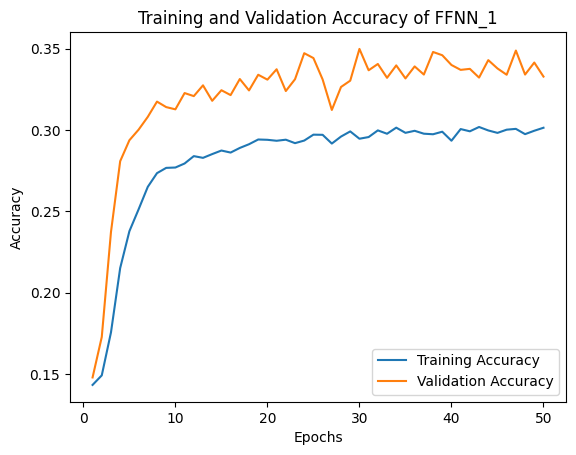

In [12]:

epochs = range(1, len(history_FFNN_1.history['accuracy']) + 1)
plt.plot(epochs, history_FFNN_1.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_FFNN_1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy of FFNN_1')
plt.legend()
plt.show()

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Confusion Matrix:


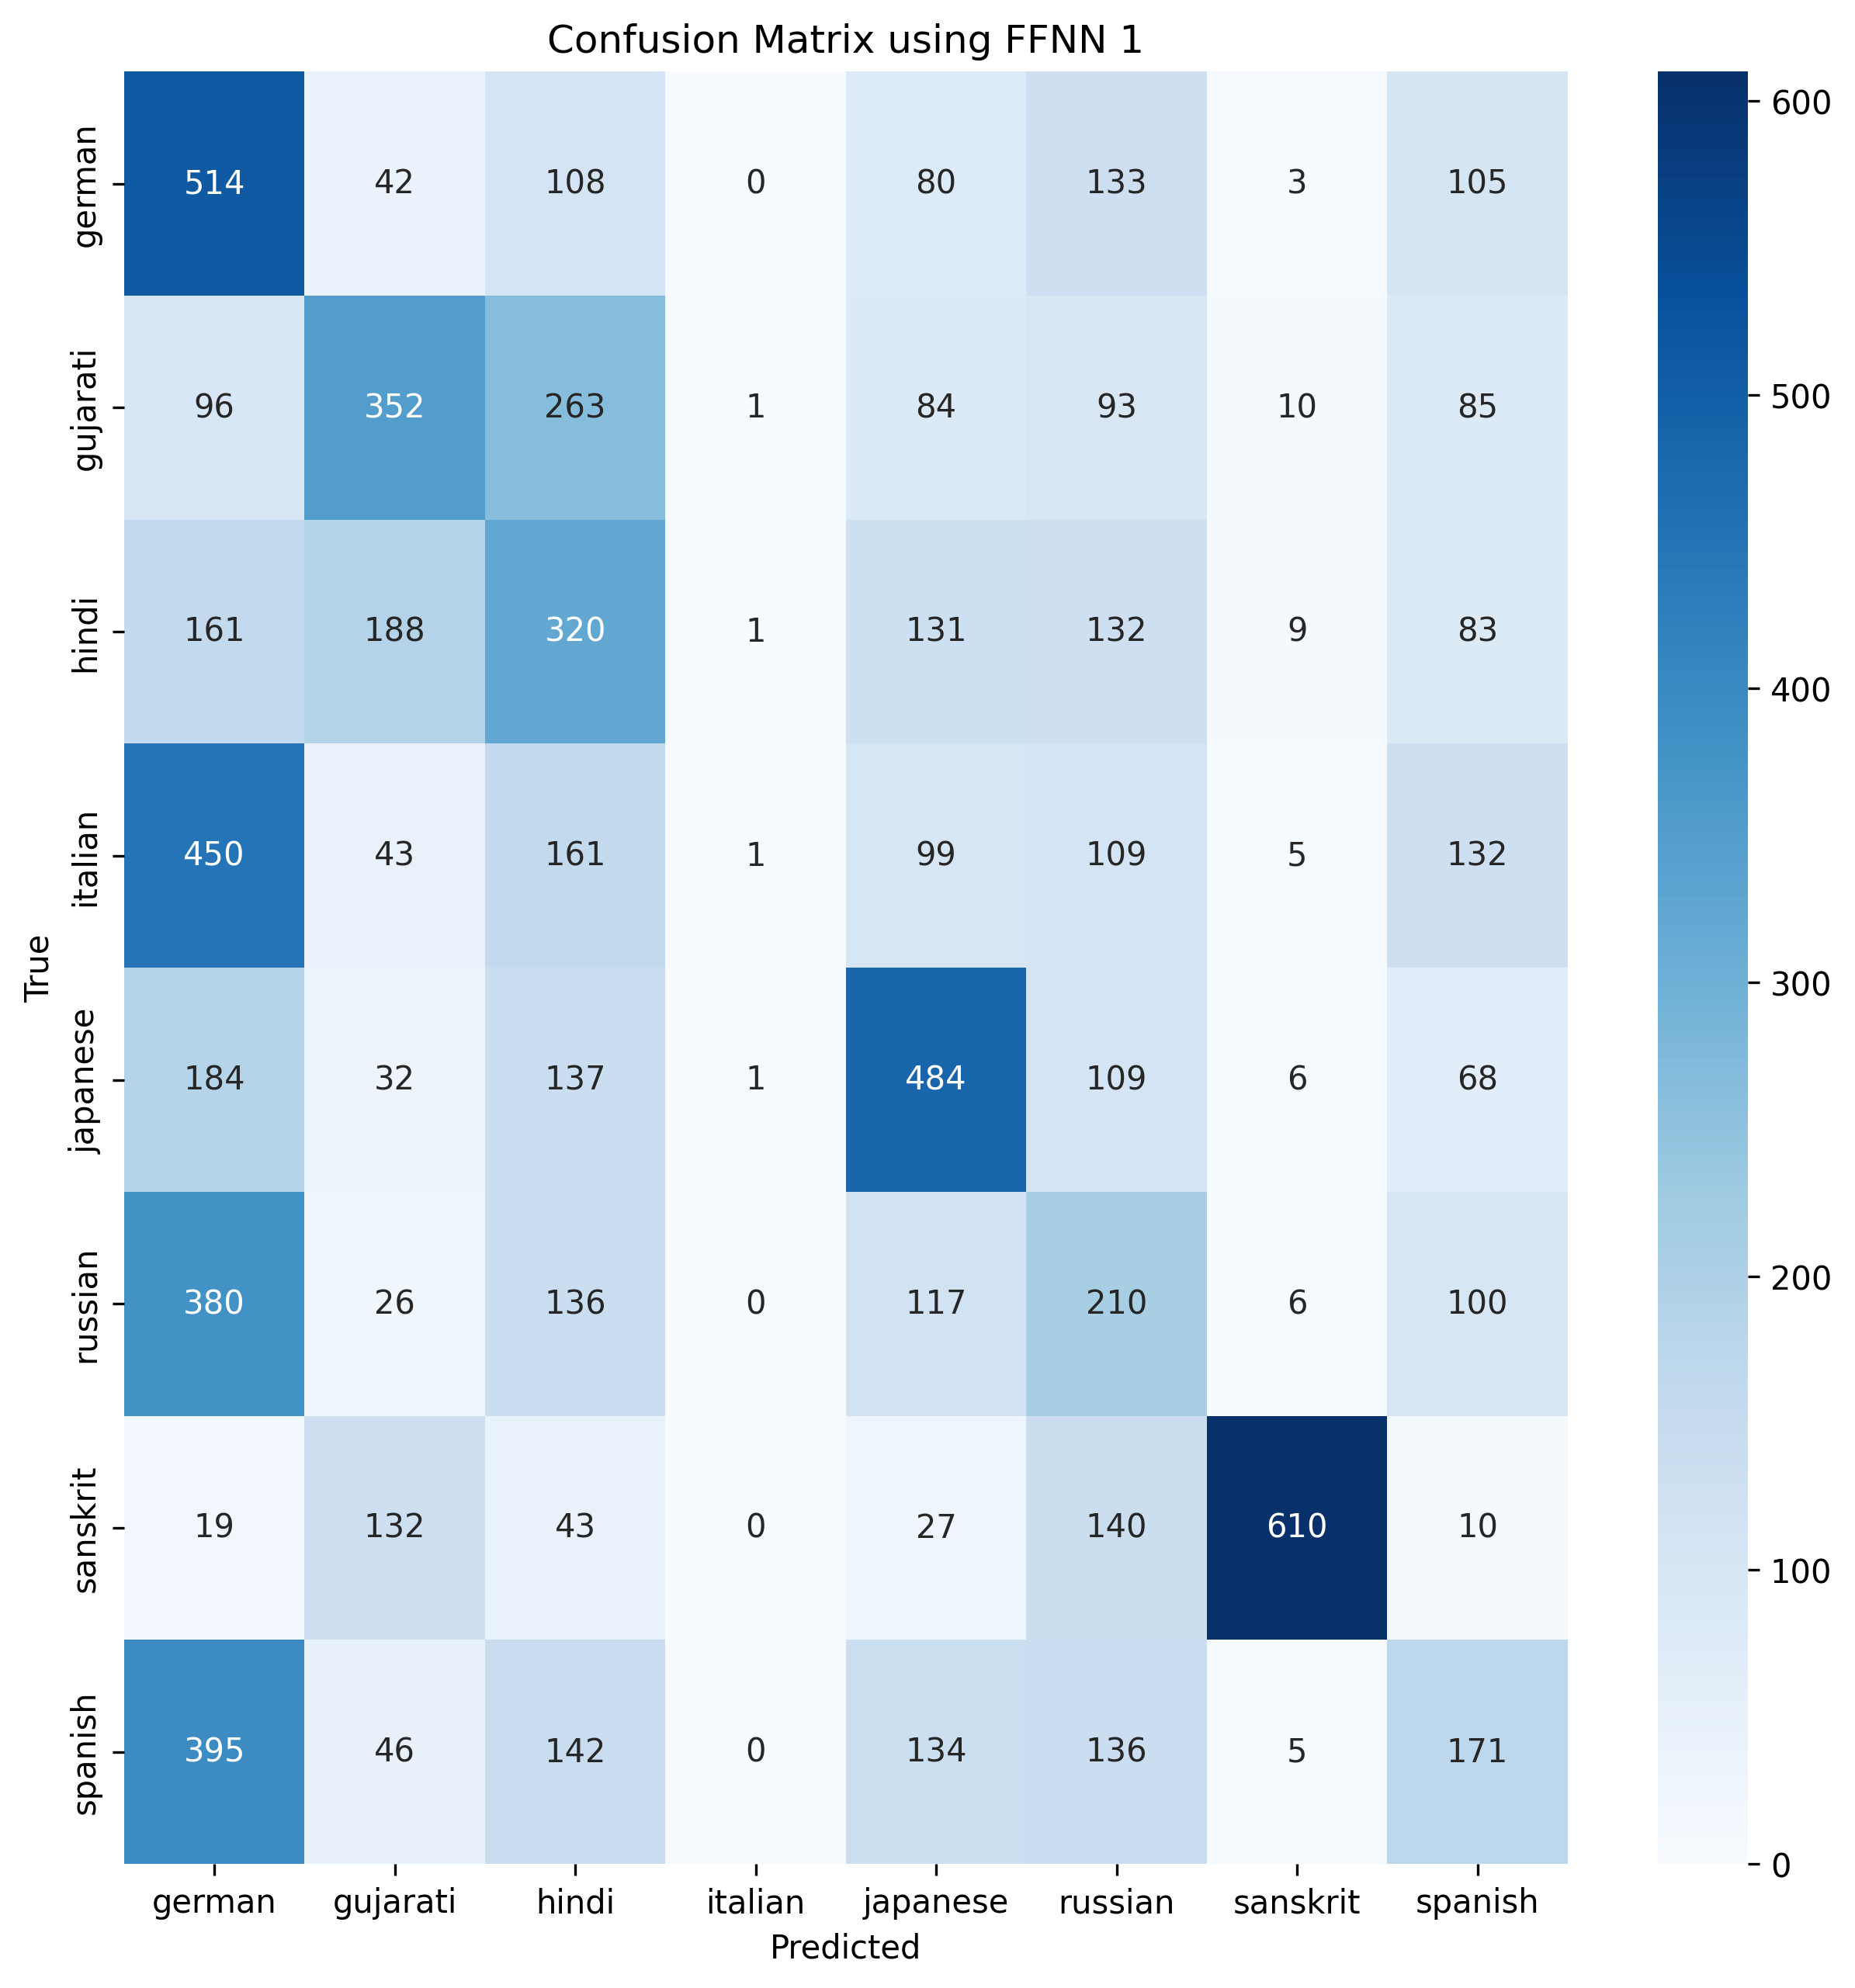

In [13]:
y_pred_prob_FFNN_1 = FFNN_1.predict(X_test)
y_pred_FFNN_1=np.argmax(y_pred_prob_FFNN_1, axis=1)
print("Confusion Matrix:")
encoded_to_original_mapping = {i: original_classes[i] for i in range(len(original_classes))}
cm = confusion_matrix(y_test, y_pred_FFNN_1)
plot_CM(y_test, y_pred_FFNN_1,original_classes,"FFNN 1")

In [14]:
FFNN_2 = Sequential()
FFNN_2.add(Input(shape=(N_MFCC,)))
FFNN_2.add(Dense(32,activation='relu')) # FFNN.add(Dense(32,activation='relu',input_shape=(40,)))


FFNN_2.add(Dropout(0.25))

FFNN_2.add(Dense(128,activation='relu'))
FFNN_2.add(Dropout(0.25))

FFNN_2.add(Dense(225,activation='relu'))
FFNN_2.add(Dropout(0.25))

FFNN_2.add(Dense(8,activation='softmax'))
FFNN_2.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history_FFNN_2 = FFNN_2.fit(X_train,y_train,epochs=50,batch_size=32,validation_data=(X_test,y_test))

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.1811 - loss: 3.8490 - val_accuracy: 0.3106 - val_loss: 1.8515
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2928 - loss: 1.8470 - val_accuracy: 0.3475 - val_loss: 1.7301
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3156 - loss: 1.7730 - val_accuracy: 0.3684 - val_loss: 1.6871
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3422 - loss: 1.7052 - val_accuracy: 0.3893 - val_loss: 1.6358
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3521 - loss: 1.6809 - val_accuracy: 0.3914 - val_loss: 1.6143
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3676 - loss: 1.6497 - val_accuracy: 0.4115 - val_loss: 1.5843
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3761 - loss: 1.6413 - val_accuracy: 0.4129 - val_loss: 1.5682
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3861 - loss: 1.6206 - 

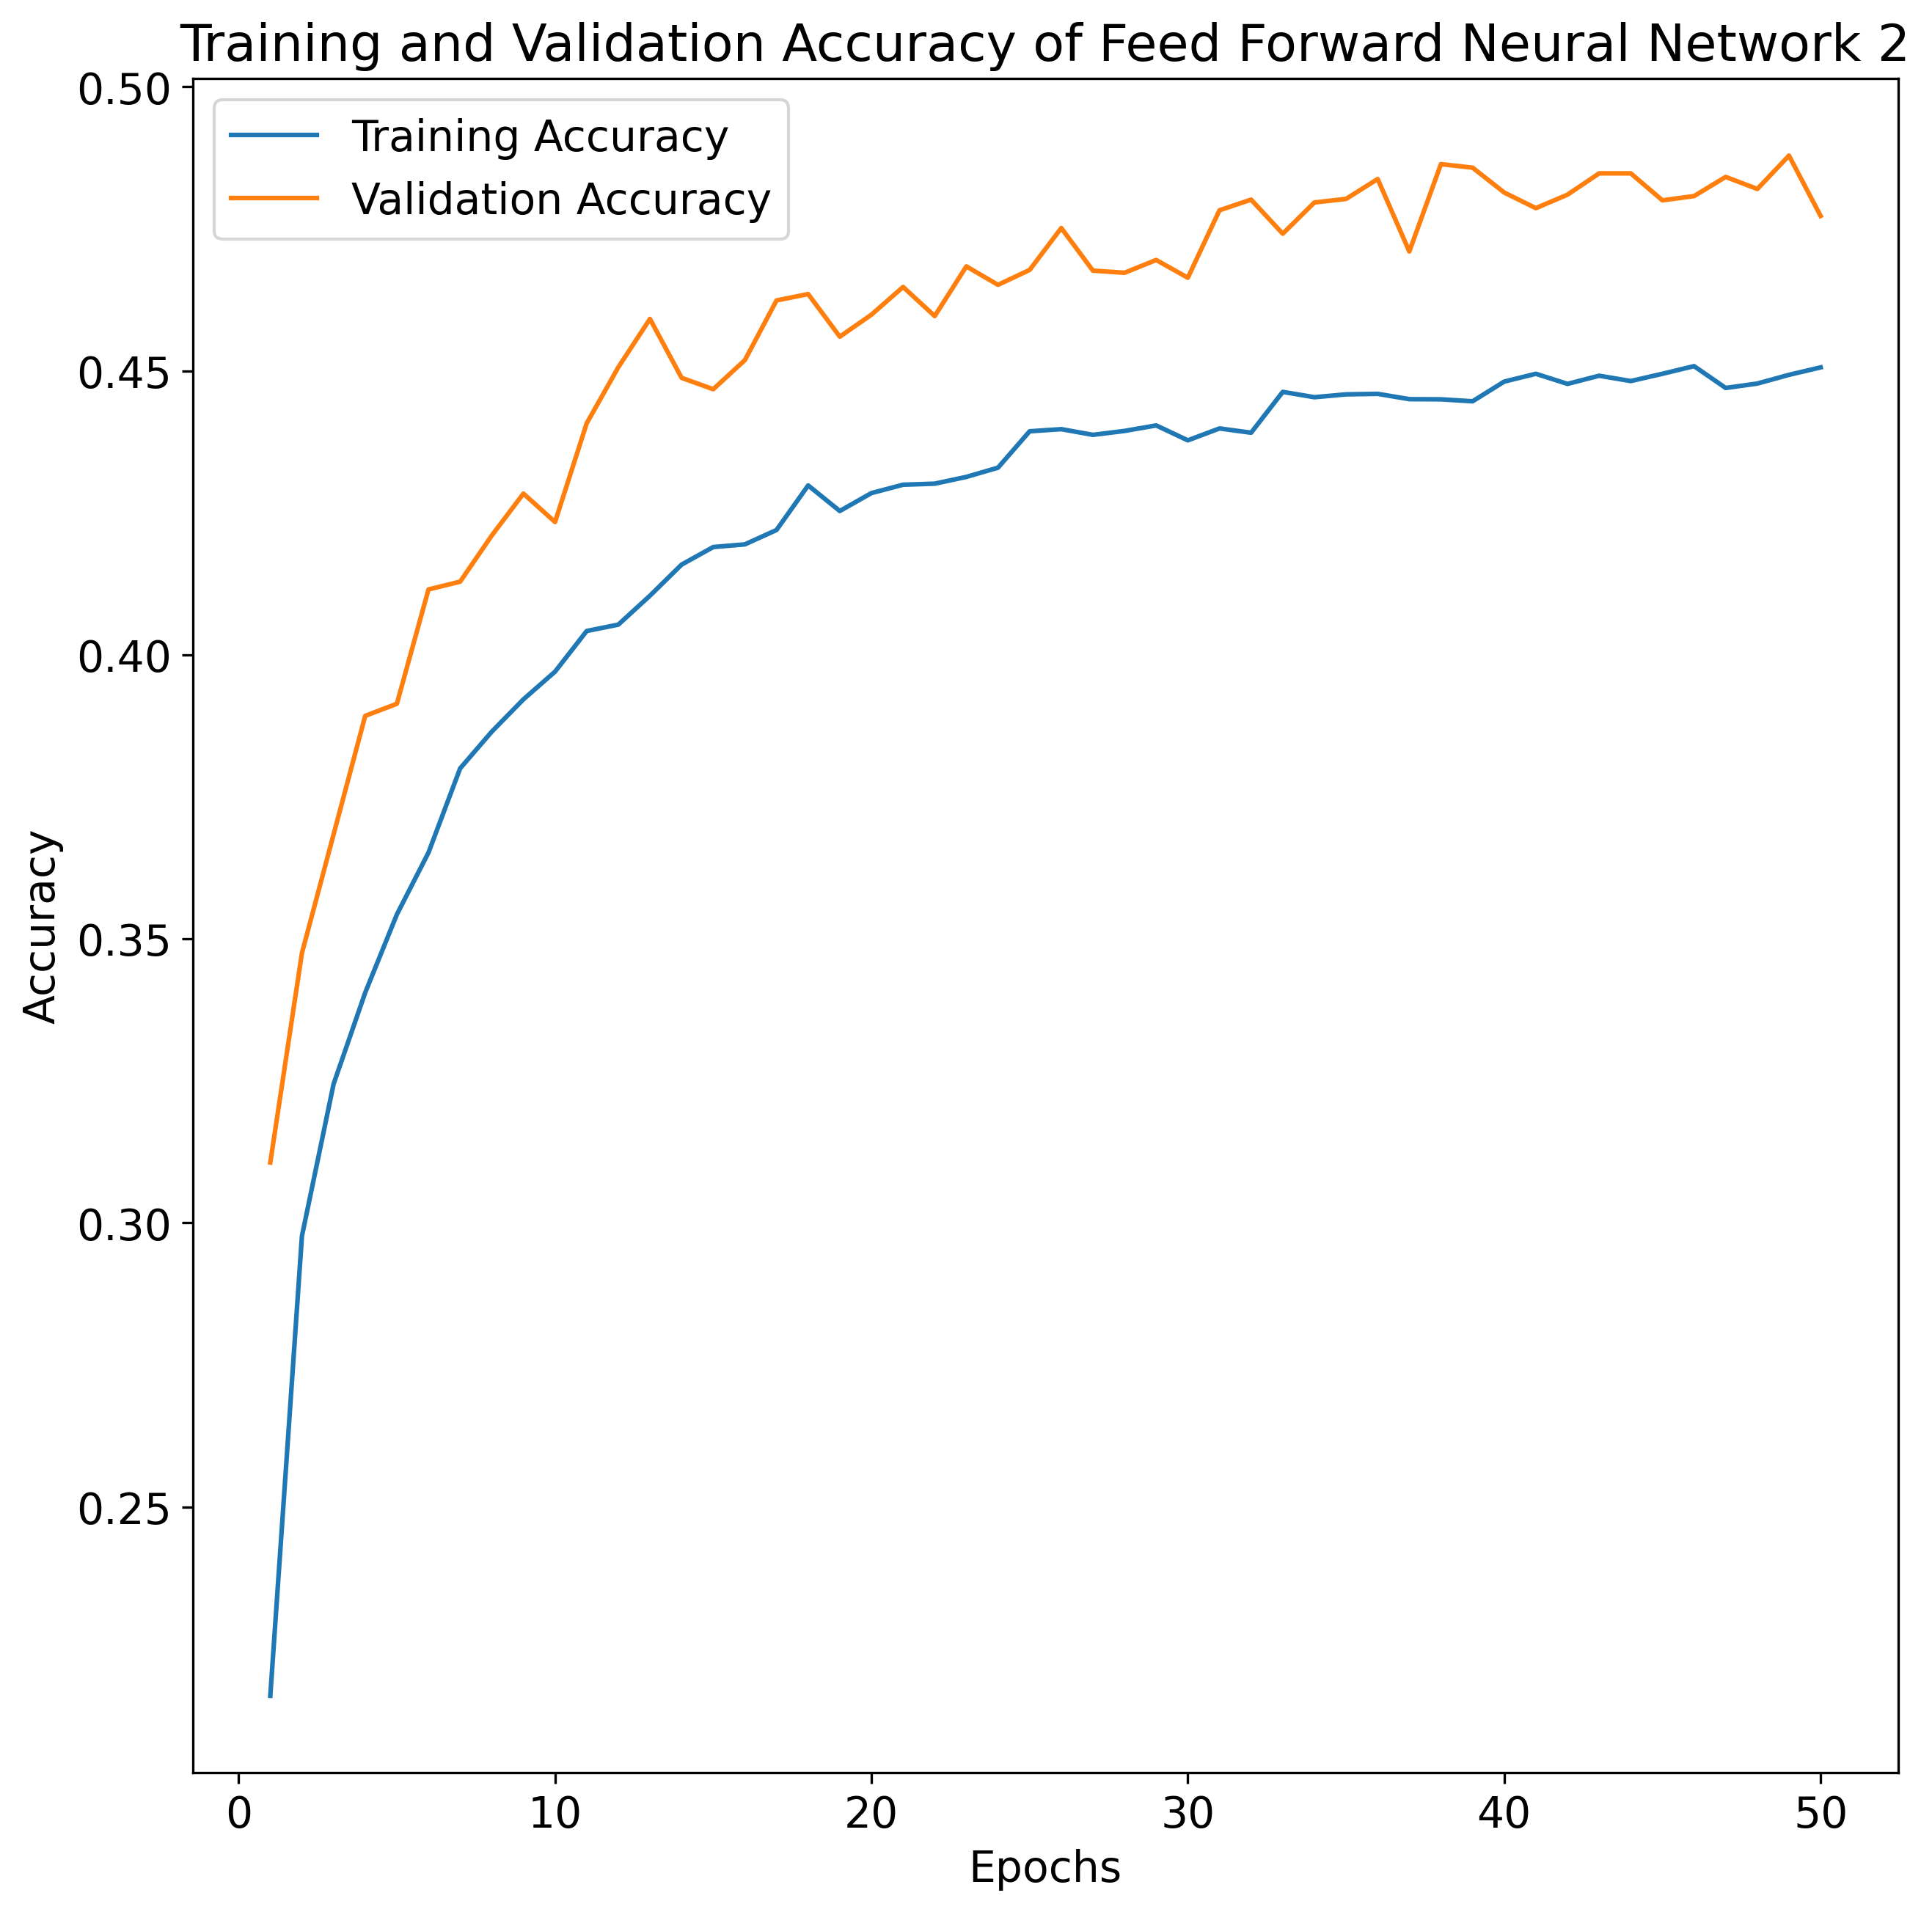

In [15]:

epochs = range(1, len(history_FFNN_2.history['accuracy']) + 1)
plt.figure(figsize=(10, 10),dpi=300)
plt.rcParams.update({'font.size': 14})
plt.plot(epochs, history_FFNN_2.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_FFNN_2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy of Feed Forward Neural Network 2')
plt.legend()
plt.savefig(f"FFNN_2.jpg")
plt.show()

In [16]:
FFNN_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 32)             │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 225)            │        29,025 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 225)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │         1,808 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,869 (448.71 KB)

 Trainable params: 38,289 (149.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 76,580 (299.14 KB)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion Matrix:


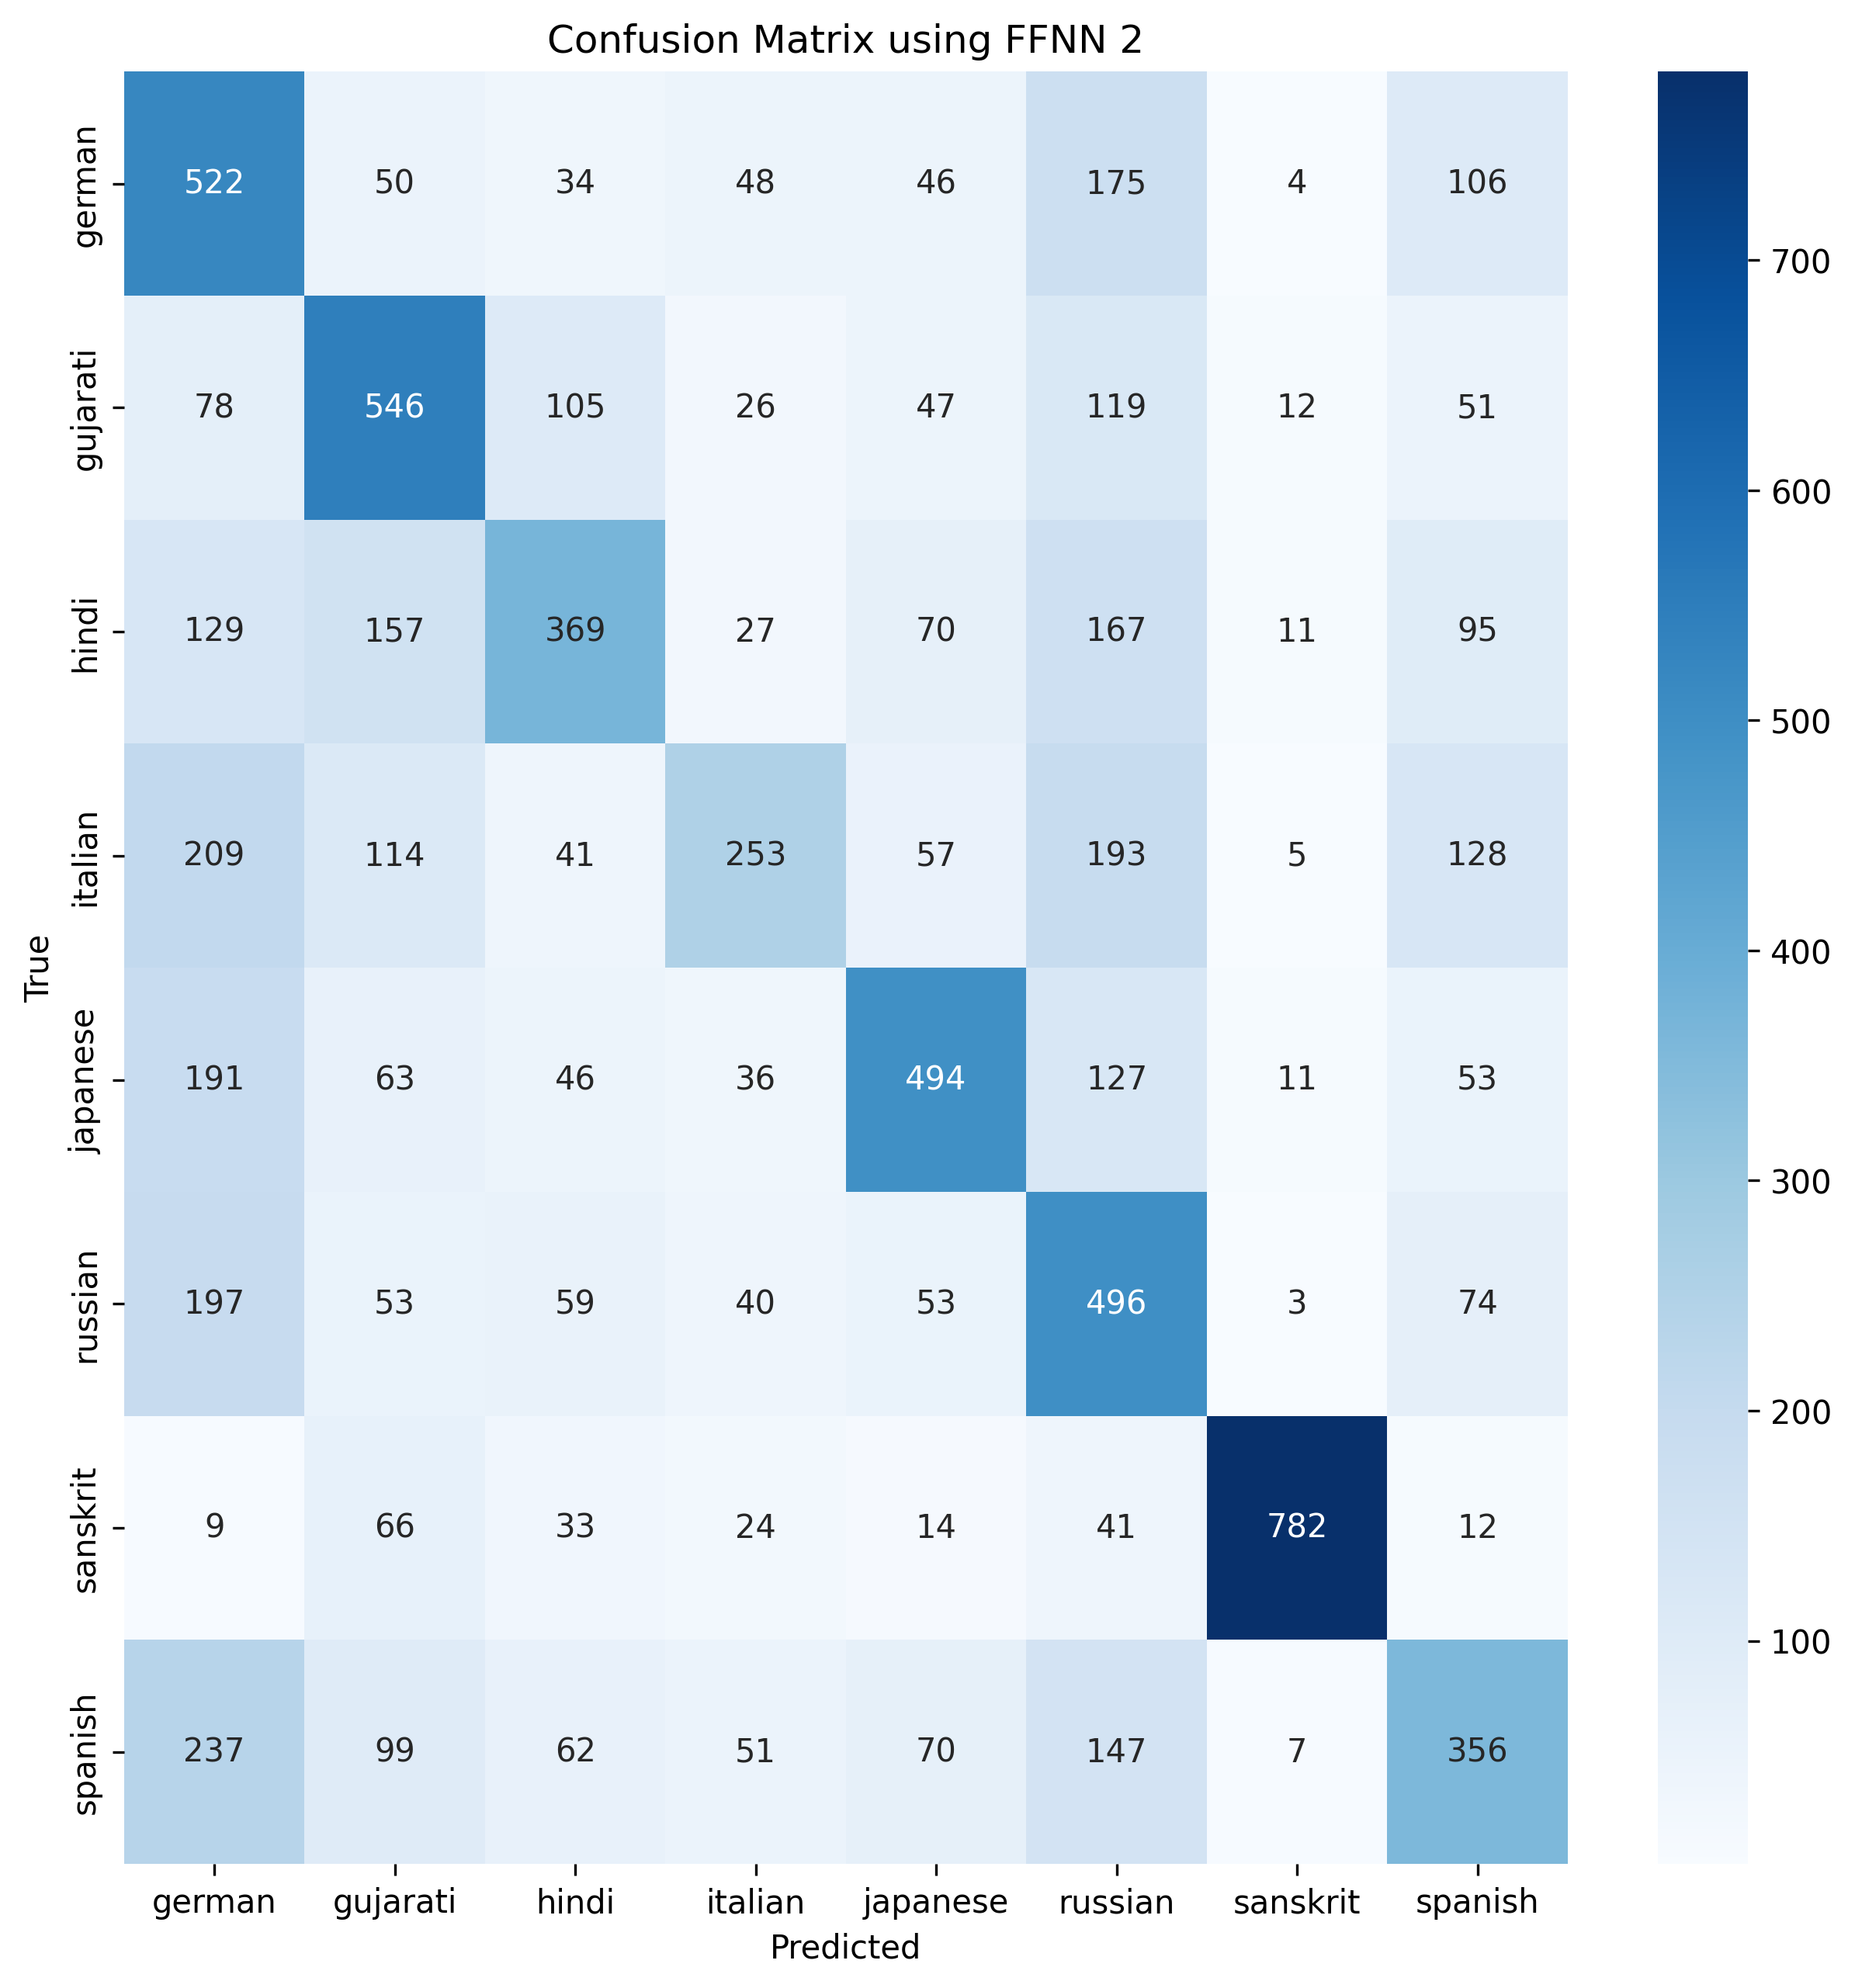

In [17]:
y_pred_prob_FFNN_2 = FFNN_2.predict(X_test)
y_pred_FFNN_2=np.argmax(y_pred_prob_FFNN_2, axis=1)
print("Confusion Matrix:")


encoded_to_original_mapping = {i: original_classes[i] for i in range(len(original_classes))}


cm = confusion_matrix(y_test, y_pred_FFNN_2)
plot_CM(y_test, y_pred_FFNN_2,original_classes,"FFNN 2")





## **Bidirectional LSTM Model 1 (BLSTM_1)**

In this section, we define and compile a Bidirectional Long Short-Term Memory (BLSTM) neural network model. This model leverages bidirectional LSTM layers to capture temporal dependencies in the audio feature sequences. 

#### **Model Architecture:**

1. **Input Layer**:
   - `Input(shape=(X_train.shape[0], X_train.shape[1]))`: Defines the input shape based on the training data dimensions. This assumes that each sequence in the dataset has the same length.

2. **Bidirectional LSTM Layers**:
   - **First Bidirectional LSTM**: `Bidirectional(LSTM(2048, return_sequences=True))`
     - This layer processes sequences in both forward and backward directions, with 2048 units and returns the full sequence.
   - **Second Bidirectional LSTM**: `Bidirectional(LSTM(1024, return_sequences=True))`
     - Similar to the first layer but with 1024 units.
   - **Third Bidirectional LSTM**: `Bidirectional(LSTM(512, return_sequences=True))`
     - With 512 units and also returns the full sequence.
   - **Fourth Bidirectional LSTM**: `Bidirectional(LSTM(256))`
     - With 256 units and does not return sequences (final output).

3. **Dropout Layers**:
   - Added after each LSTM layer to prevent overfitting by randomly setting a fraction of input units to 0 during training.

4. **Dense Layer**:
   - `Dense(8, activation='softmax')`: Final dense layer with 8 units and a softmax activation function to output class probabilities.

#### **Compilation:**

- **Optimizer**: Adam optimizer with a learning rate of 0.001, chosen to optimize the model's weights during training.
- **Loss Function**: Sparse categorical cross-entropy, suitable for multi-class classification problems.
- **Metrics**: Accuracy, to evaluate the model's performance.

Finally, the model summary provides an overview of the model architecture, including the number of parameters and layer details.


In [18]:

# Define the model
BLSTM_1 = Sequential()
BLSTM_1.add(Input(shape=(X_train.shape[0], X_train.shape[1])))
# Add bidirectional LSTM layer
# BLSTM_1.add(Bidirectional(LSTM(2048, return_sequences=True), input_shape=(None, 40)))
BLSTM_1.add(Bidirectional(LSTM(2048, return_sequences=True)))
BLSTM_1.add(Dropout(0.5))

BLSTM_1.add(Bidirectional(LSTM(1024, return_sequences=True)))
BLSTM_1.add(Dropout(0.5))

BLSTM_1.add(Bidirectional(LSTM(512, return_sequences=True)))
BLSTM_1.add(Dropout(0.5))

BLSTM_1.add(Bidirectional(LSTM(256)))
BLSTM_1.add(Dropout(0.5))

BLSTM_1.add(Dense(8, activation='softmax'))

# Compile the model
learning_rate = 0.001  # Set your desired learning rate here

# Create an instance of the Adam optimizer with the desired learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the new optimizer
BLSTM_1.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Print model summary
BLSTM_1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 32000, 4096)    │    35,209,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32000, 4096)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32000, 2048)    │    41,951,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32000, 2048)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 32000, 1024)    │    10,489,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32000, 1024)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     2,623,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,277,896 (344.38 MB)

 Trainable params: 90,277,896 (344.38 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
X_train.shape

(32000, 100)

### ** Reshaping Training and Testing Data**

Before feeding the data into the Bidirectional LSTM model, we need to ensure that it is in the correct shape. LSTM networks expect input data to be in the format `[samples, time steps, features]`. Here, we reshape the data accordingly.

#### **Reshaping Training Data:**

1. **`X_train`**:
   - Original shape: `[number of samples, number of features]`
   - Reshaped shape: `[number of samples, 1, number of features]`
   - This reshaping adds an extra dimension to represent the time steps as `1` (i.e., each sample is treated as a single time step).

2. **`y_train`**:
   - Reshaped to `[number of samples, 1]`
   - This transformation ensures that `y_train` is in the correct shape for training.

#### **Reshaping Testing Data:**

1. **`X_test`**:
   - Original shape: `[number of samples, number of features]`
   - Reshaped shape: `[number of samples, 1, number of features]`
   - This reshaping aligns the testing data with the input requirements of the LSTM model.

2. **`y_test`**:
   - Reshaped to `[number of samples, 1]`
   - This transformation ensures that `y_test` matches the shape expected by the model during evaluation.

By verifying the shapes before and after reshaping, we confirm that the data is correctly formatted for model training and evaluation.


In [20]:

# Reshape X_train
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

# Verify the new shape
print("Original shape:", X_train.shape)
print("Reshaped shape:", X_train_reshaped.shape)

y_train_reshaped = np.reshape(y_train, (-1, 1))  # Assuming y_train is already one-dimensional
y_test_reshaped = np.reshape(y_test, (-1, 1))  # Assuming y_test is already one-dimensional

# Verify the new shapes
print("Original y_train shape:", y_train.shape)
print("Reshaped y_train shape:", y_train_reshaped.shape)
print("Original y_test shape:", y_test.shape)
print("Reshaped y_test shape:", y_test_reshaped.shape)

# Reshape X_test
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Verify the new shape
print("Original X_test shape:", X_test.shape)
print("Reshaped X_test shape:", X_test_reshaped.shape)

Original shape: (32000, 100)
Reshaped shape: (32000, 1, 100)
Original y_train shape: (32000,)
Reshaped y_train shape: (32000, 1)
Original y_test shape: (8000,)
Reshaped y_test shape: (8000, 1)
Original X_test shape: (8000, 100)
Reshaped X_test shape: (8000, 1, 100)


In [21]:
history_BLSTM_1 = BLSTM_1.fit(X_train_reshaped,y_train_reshaped,epochs=50,batch_size=512,validation_data=(X_test_reshaped,y_test_reshaped))

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 155ms/step - accuracy: 0.2581 - loss: 1.8918 - val_accuracy: 0.3983 - val_loss: 1.5777
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.4268 - loss: 1.5372 - val_accuracy: 0.4849 - val_loss: 1.4096
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.4838 - loss: 1.4031 - val_accuracy: 0.5380 - val_loss: 1.2936
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.5317 - loss: 1.2887 - val_accuracy: 0.5745 - val_loss: 1.2194
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.5660 - loss: 1.2069 - val_accuracy: 0.5778 - val_loss: 1.1855
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.5930 - loss: 1.1477 - val_accuracy: 0.6202 - val_loss: 1.0966
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.6106 - loss: 1.0912 - val_accuracy: 0.6365 - val_loss: 1.0554
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.6407 - loss: 1.0250 - val_accuracy

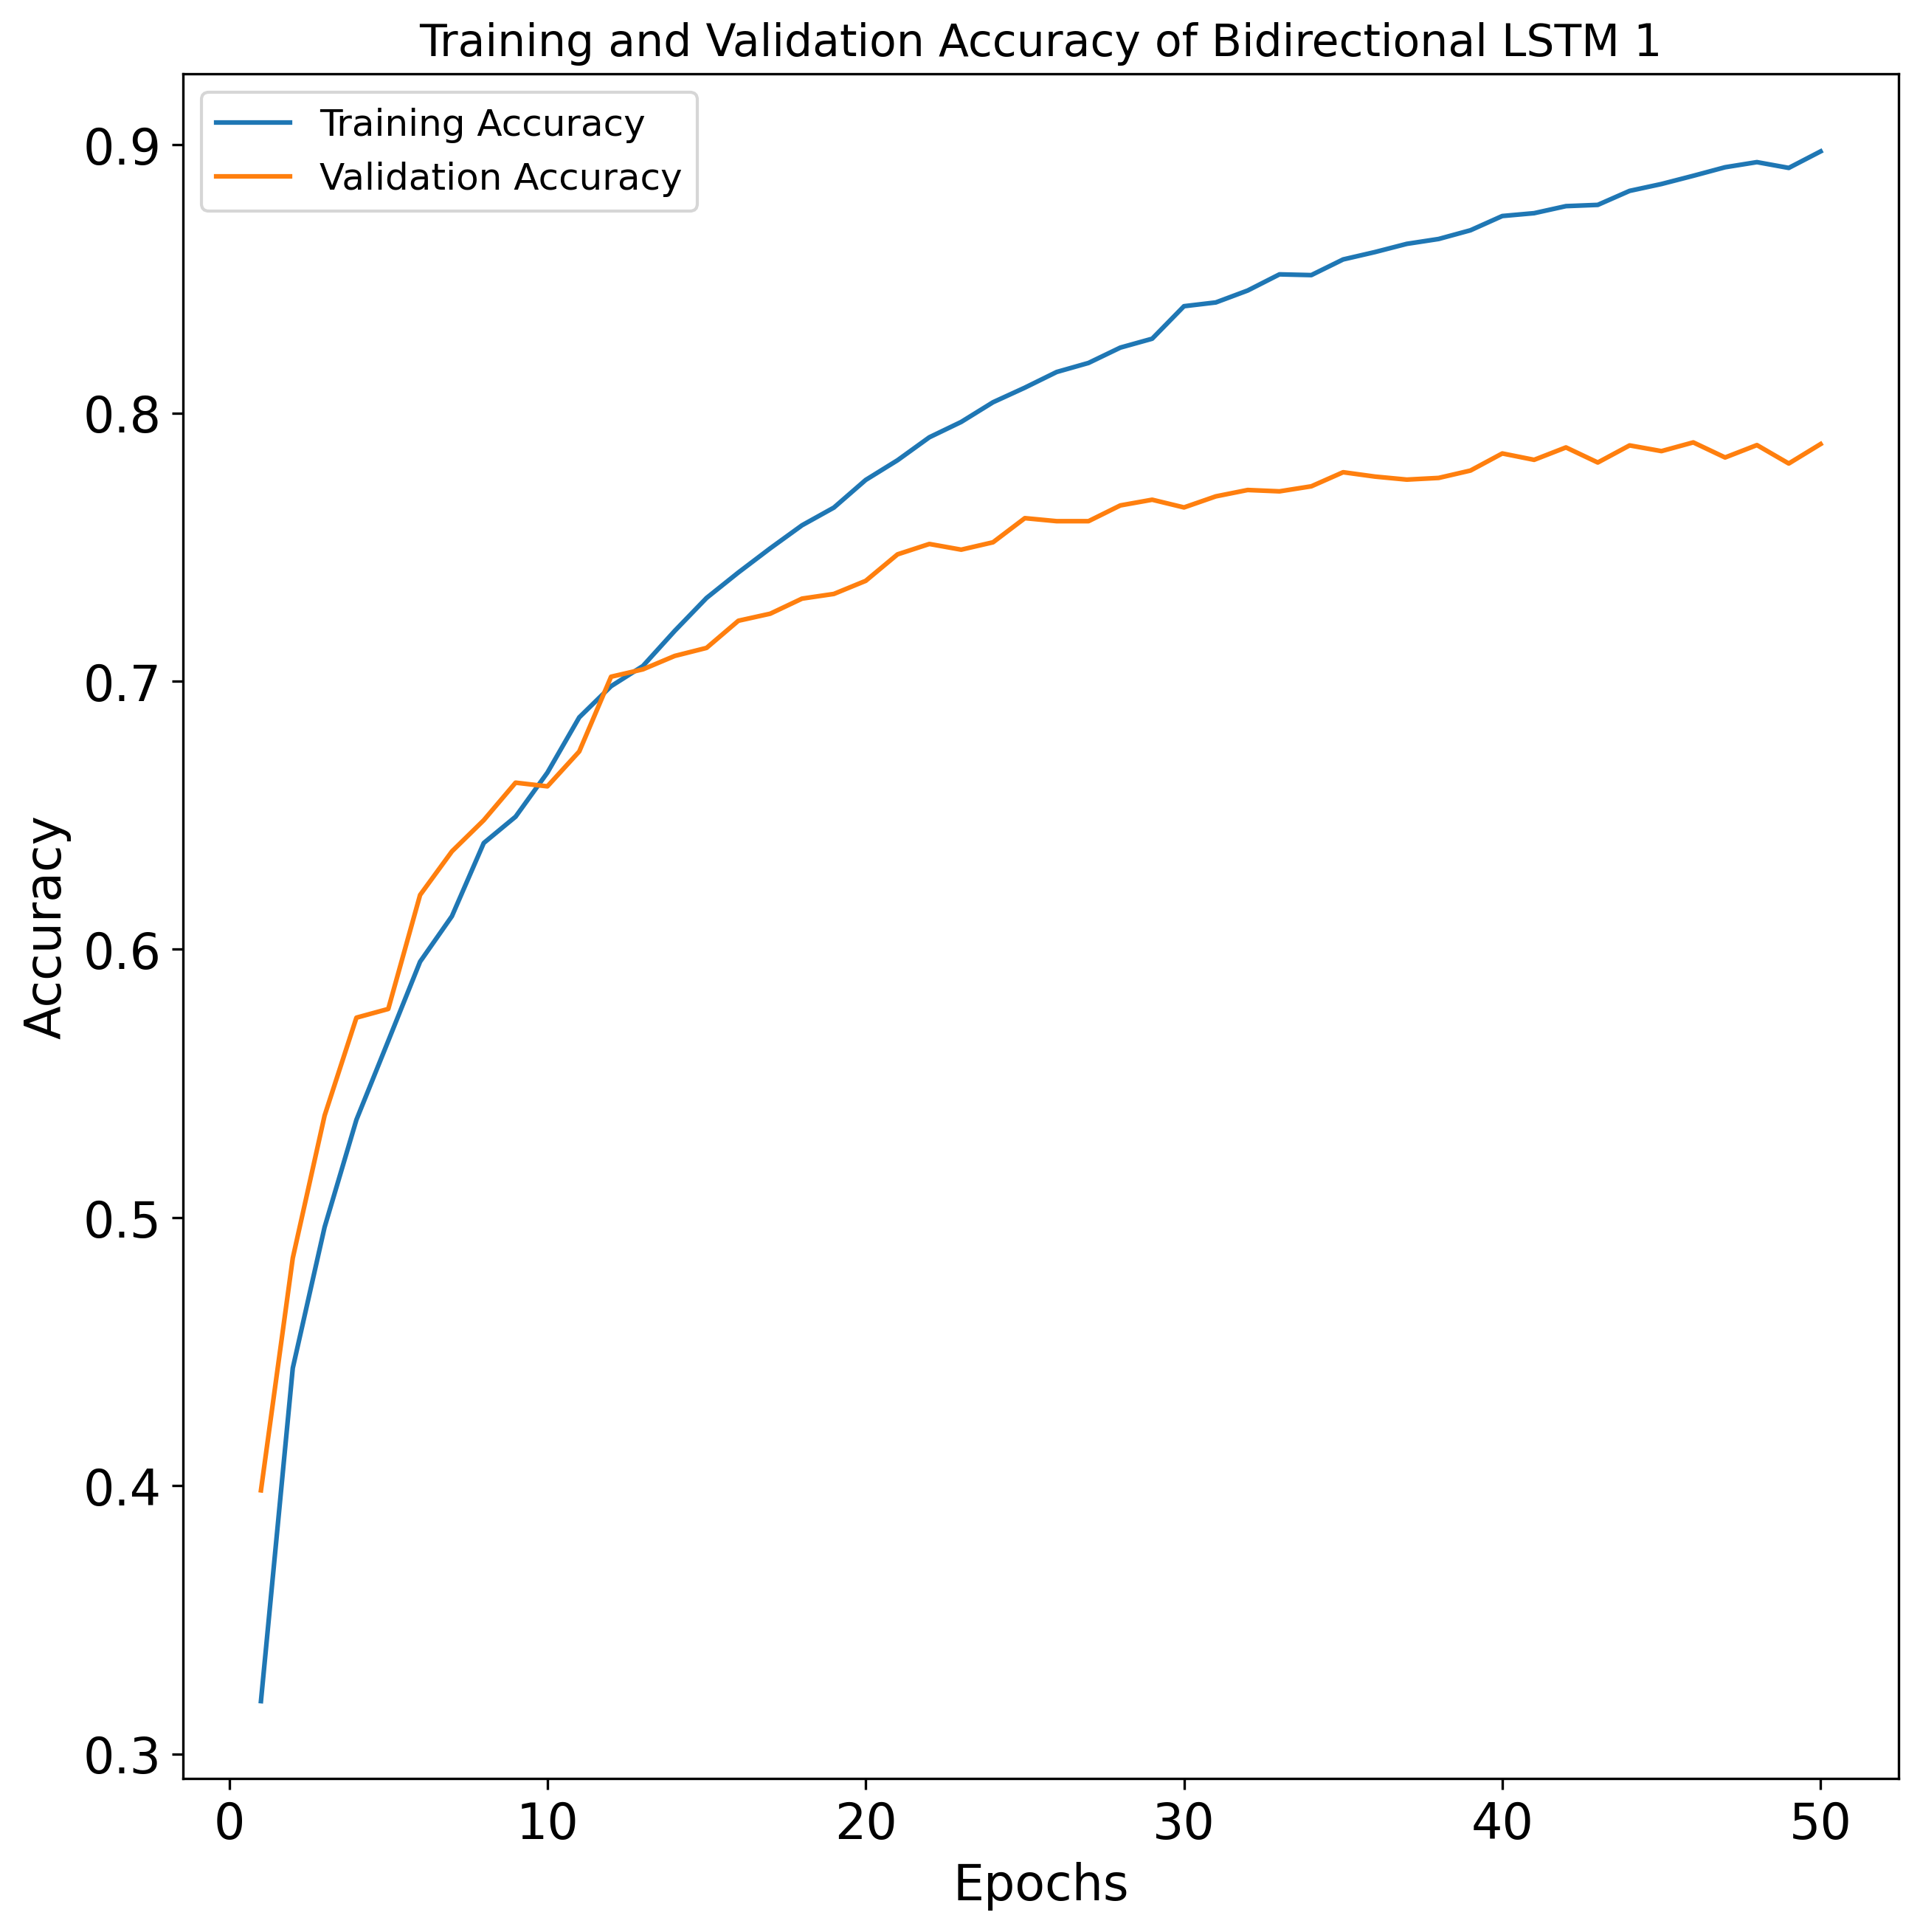

In [22]:
epochs = range(1, len(history_BLSTM_1.history['accuracy']) + 1)
plt.figure(figsize=(10, 10),dpi=300)
plt.rcParams.update({'font.size': 16})
plt.plot(epochs, history_BLSTM_1.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_BLSTM_1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.rcParams['font.size'] = 12

plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy of Bidirectional LSTM 1')
plt.legend()
plt.savefig('BLSTM_1.jpg')
plt.show()

250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
Confusion Matrix:


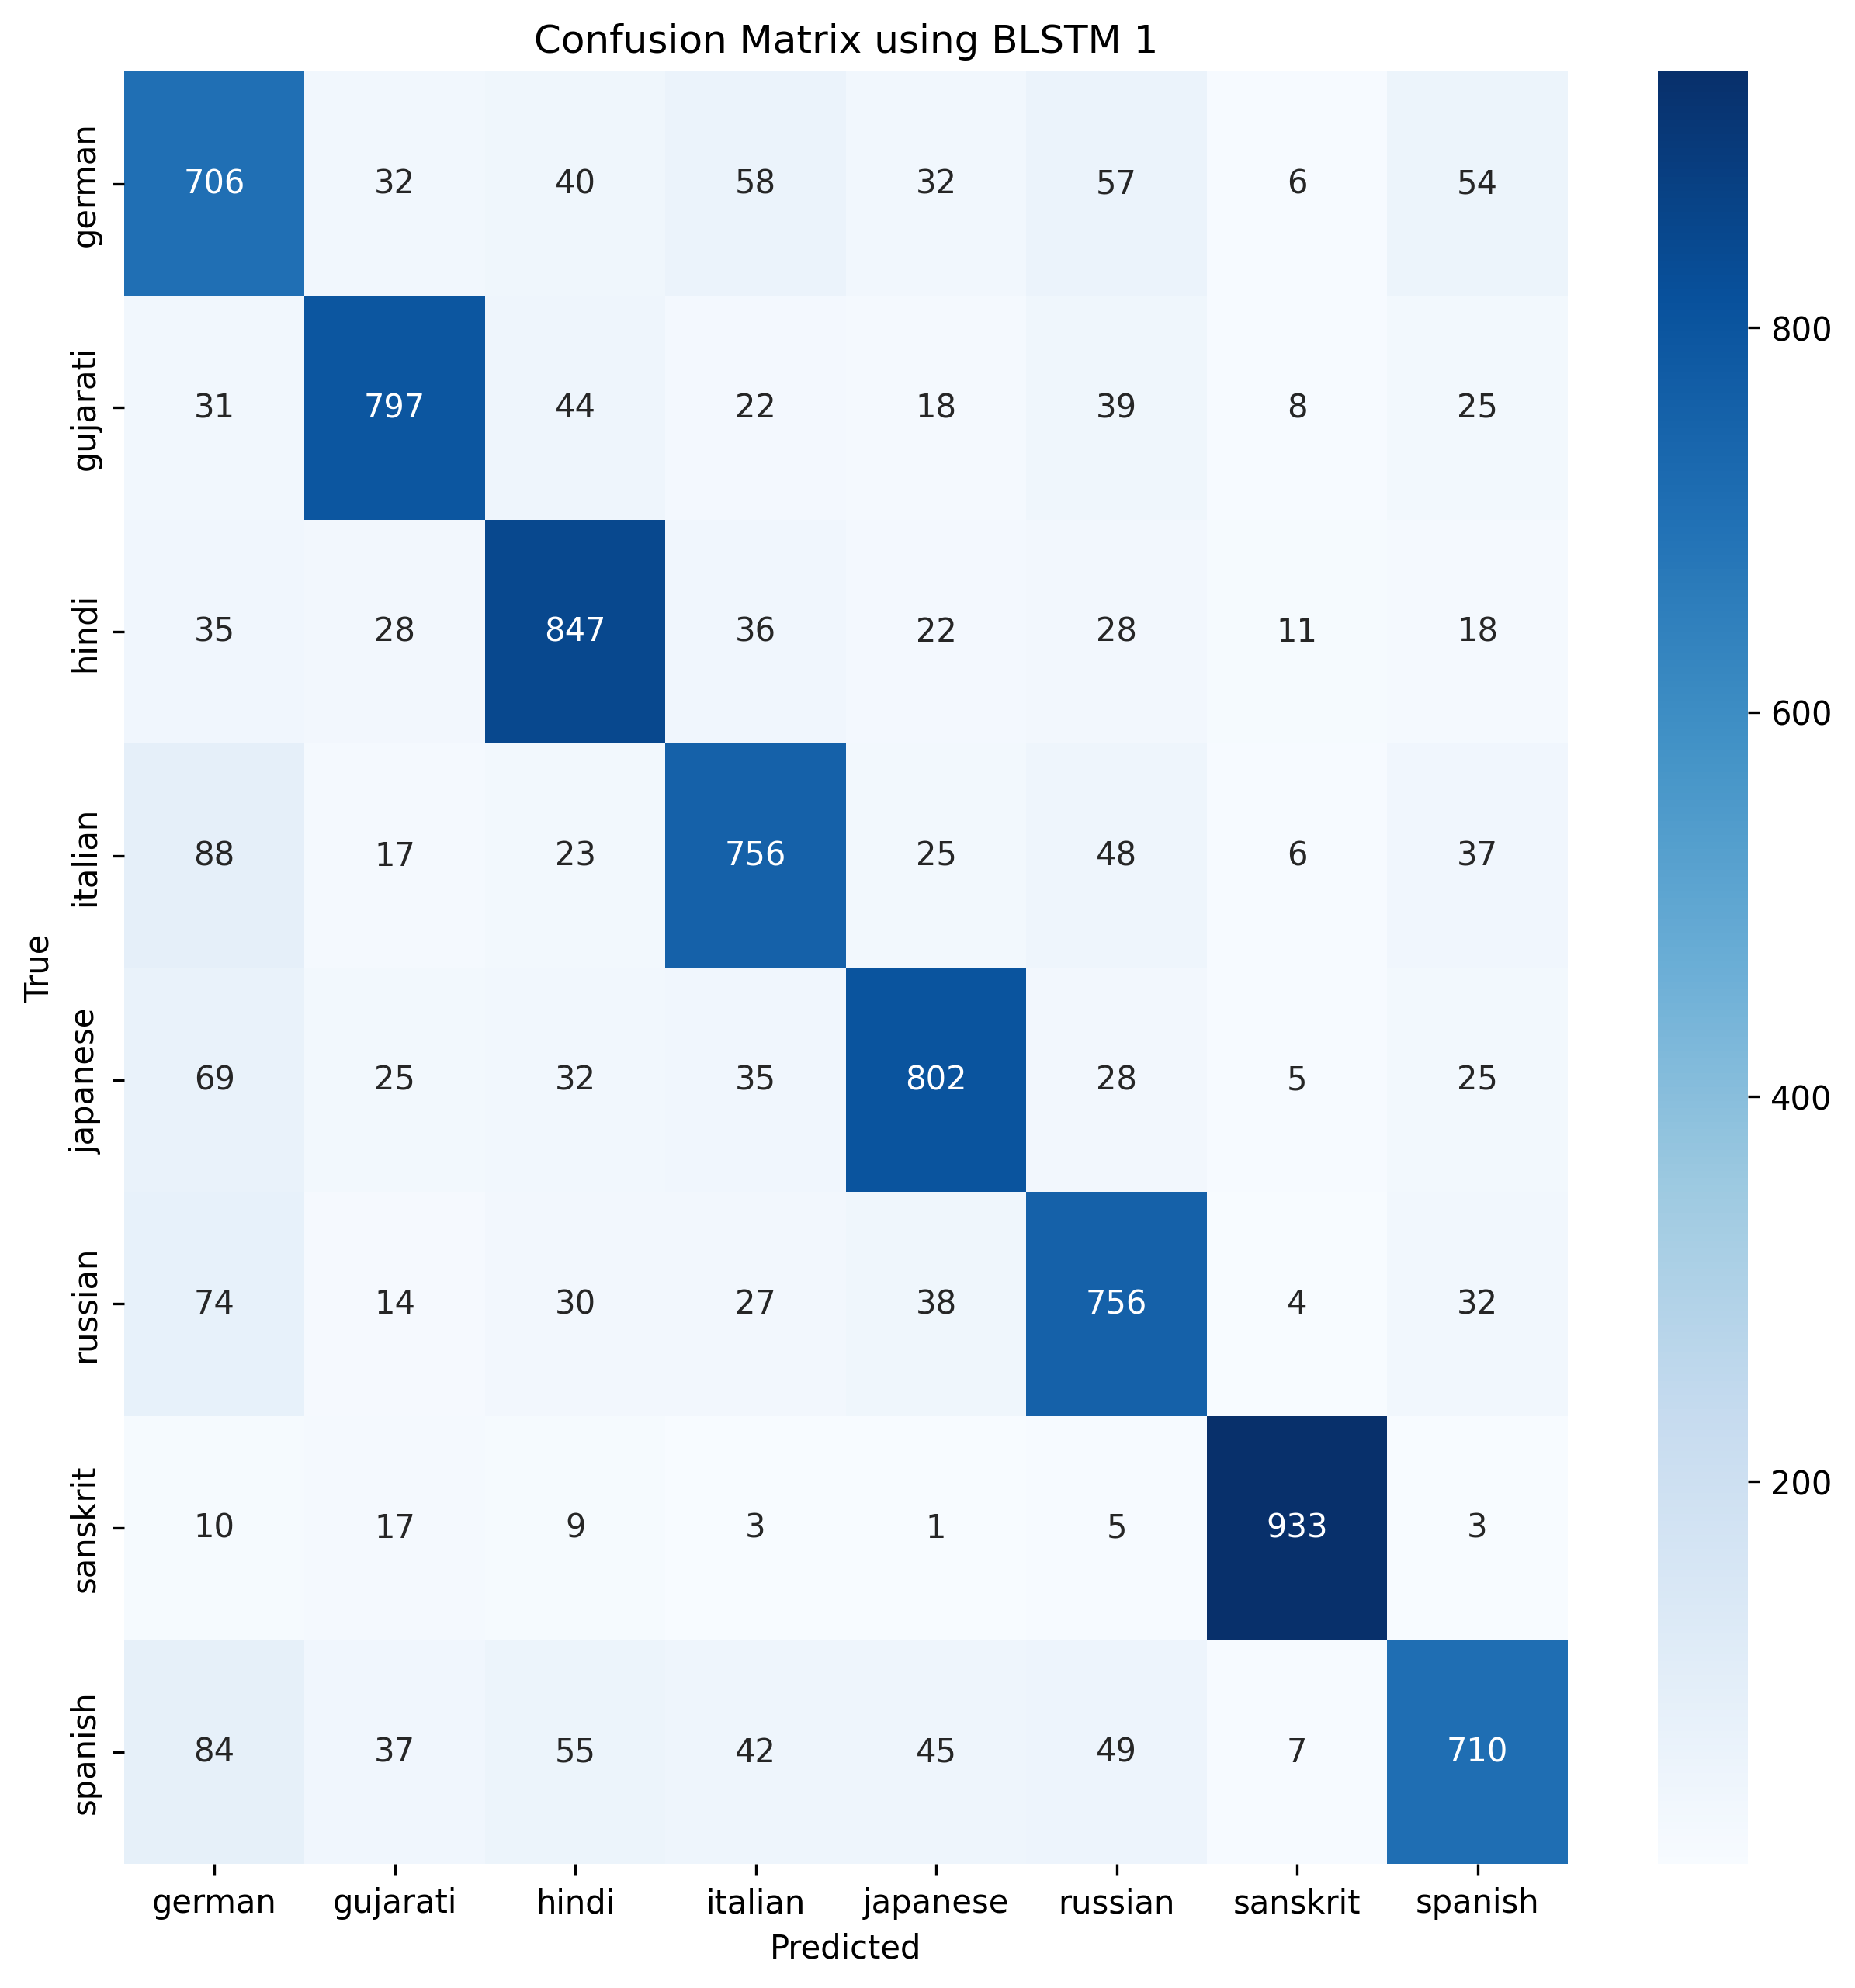

In [23]:
y_pred_prob_BLSTM_1 = BLSTM_1.predict(X_test_reshaped)
y_pred_BLSTM_1=np.argmax(y_pred_prob_BLSTM_1, axis=1)
print("Confusion Matrix:")
encoded_to_original_mapping = {i: original_classes[i] for i in range(len(original_classes))}
cm = confusion_matrix(y_test_reshaped, y_pred_BLSTM_1)
plot_CM(y_test_reshaped, y_pred_BLSTM_1,original_classes,"BLSTM 1")

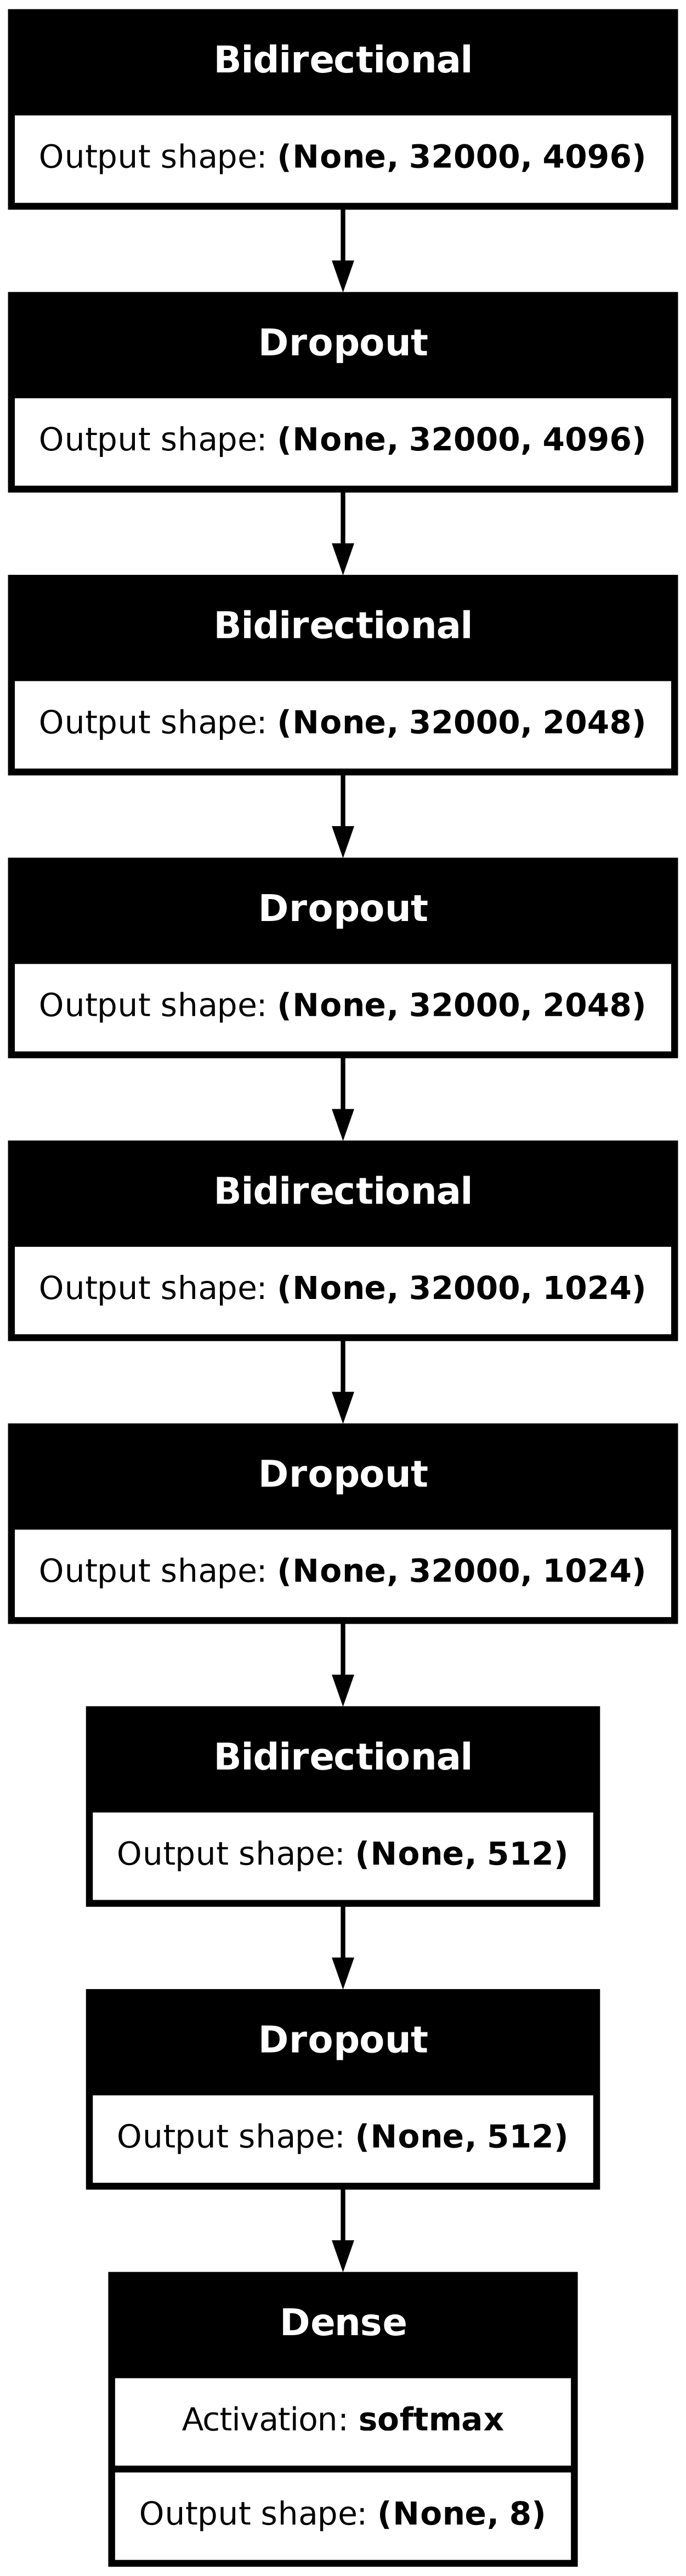

In [24]:
from keras.utils import plot_model
plot_model(BLSTM_1, to_file='BLSTM_1_V.png',dpi=300,show_layer_activations=True,show_shapes=True,rankdir='TB',expand_nested=True)

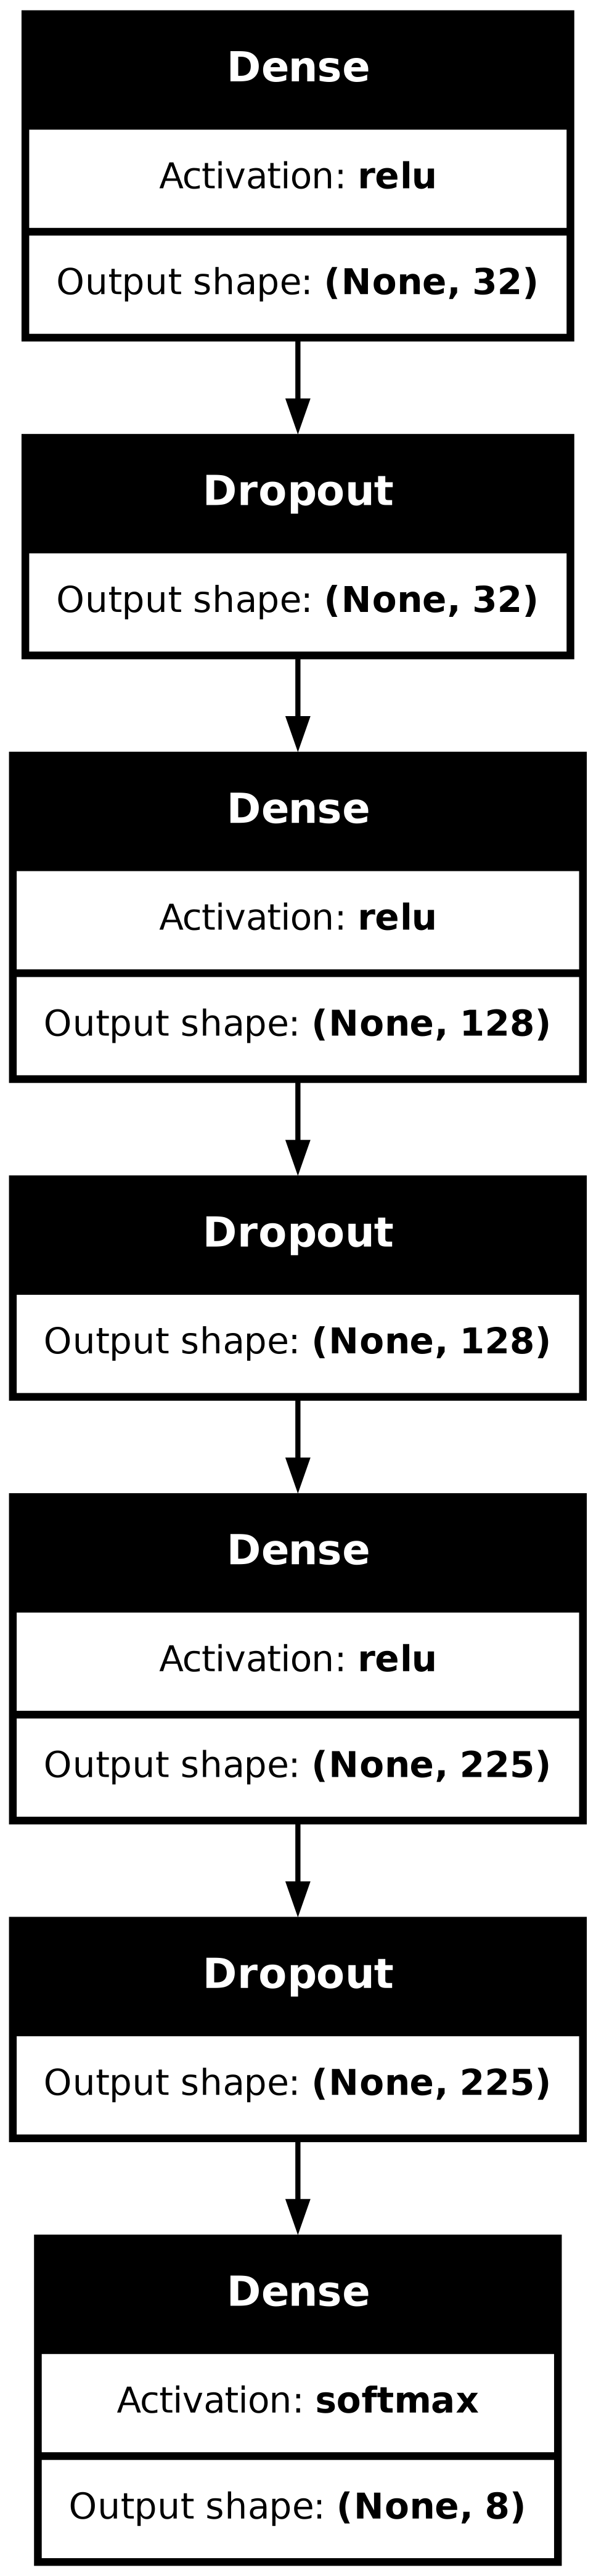

In [25]:
plot_model(FFNN_2, to_file='FFNN_2_V.png',dpi=300,show_layer_activations=True,show_shapes=True,rankdir='TB',expand_nested=True)

## **Bidirectional LSTM Model 2 (BLSTM_2)**

In this section, we define and compile a second Bidirectional LSTM model, `BLSTM_2`, with a different architecture compared to `BLSTM_1`. This model incorporates multiple Bidirectional LSTM layers with varied units and dropout rates to explore its impact on model performance.

#### **Model Architecture:**

1. **Input Layer:**
   - Input shape: `(X_train.shape[0], X_train.shape[1])`
   - This specifies the shape of the input data, where `X_train.shape[1]` represents the number of features.

2. **Bidirectional LSTM Layers:**
   - **First Layer:** 2048 units, returns sequences
   - **Second Layer:** 1024 units, returns sequences
   - **Third Layer:** 512 units, returns sequences
   - **Fourth Layer:** 256 units, returns sequences
   - **Fifth Layer:** 64 units, does not return sequences

   Each Bidirectional LSTM layer is followed by a Dropout layer to reduce overfitting.

3. **Dropout Layers:**
   - Applied after each LSTM layer with a dropout rate of 0.25.

4. **Dense Output Layer:**
   - 8 units with a `softmax` activation function to output probabilities for 8 classes.

#### **Model Compilation:**

- **Optimizer:** Adam
  - Learning Rate: 0.0008
  - This is a lower learning rate to potentially achieve better convergence.

- **Loss Function:** Sparse Categorical Crossentropy
- **Metrics:** Accuracy

Finally, we compile the model and display its summary to review the architecture and parameter details.


In [26]:

# Define the model
BLSTM_2 = Sequential()
BLSTM_2.add(Input(shape=(X_train.shape[0], X_train.shape[1])))
# Add bidirectional LSTM layer
# BLSTM_1.add(Bidirectional(LSTM(2048, return_sequences=True), input_shape=(None, 40)))

BLSTM_2.add(Bidirectional(LSTM(2048, return_sequences=True)))
BLSTM_2.add(Dropout(0.25))

BLSTM_2.add(Bidirectional(LSTM(1024, return_sequences=True)))
BLSTM_2.add(Dropout(0.25))

BLSTM_2.add(Bidirectional(LSTM(512, return_sequences=True)))
BLSTM_2.add(Dropout(0.25))

BLSTM_2.add(Bidirectional(LSTM(256, return_sequences=True)))
BLSTM_2.add(Dropout(0.25))


BLSTM_2.add(Bidirectional(LSTM(64)))
BLSTM_2.add(Dropout(0.25))

BLSTM_2.add(Dense(8, activation='softmax'))

# Compile the model
learning_rate = 0.0008  # Set your desired learning rate here

# Create an instance of the Adam optimizer with the desired learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the new optimizer
BLSTM_2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Print model summary
BLSTM_2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 32000, 4096)    │    35,209,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32000, 4096)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 32000, 2048)    │    41,951,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32000, 2048)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 32000, 1024)    │    10,489,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32000, 1024)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 32000, 512)     │     2,623,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32000, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 128)            │       295,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,570,248 (345.50 MB)

 Trainable params: 90,570,248 (345.50 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history_BLSTM_2 = BLSTM_2.fit(X_train_reshaped,y_train_reshaped,epochs=50,batch_size=512,validation_data=(X_test_reshaped,y_test_reshaped))

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 165ms/step - accuracy: 0.2381 - loss: 1.9318 - val_accuracy: 0.3794 - val_loss: 1.6130
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.4093 - loss: 1.5633 - val_accuracy: 0.4605 - val_loss: 1.4627
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.4897 - loss: 1.3908 - val_accuracy: 0.5107 - val_loss: 1.3397
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.5520 - loss: 1.2469 - val_accuracy: 0.5790 - val_loss: 1.1974
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.6080 - loss: 1.1083 - val_accuracy: 0.6121 - val_loss: 1.1115
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.6514 - loss: 1.0042 - val_accuracy: 0.6338 - val_loss: 1.0630
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.6917 - loss: 0.9005 - val_accuracy: 0.6556 - val_loss: 1.0156
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.7147 - loss: 0.8256 - val_accu

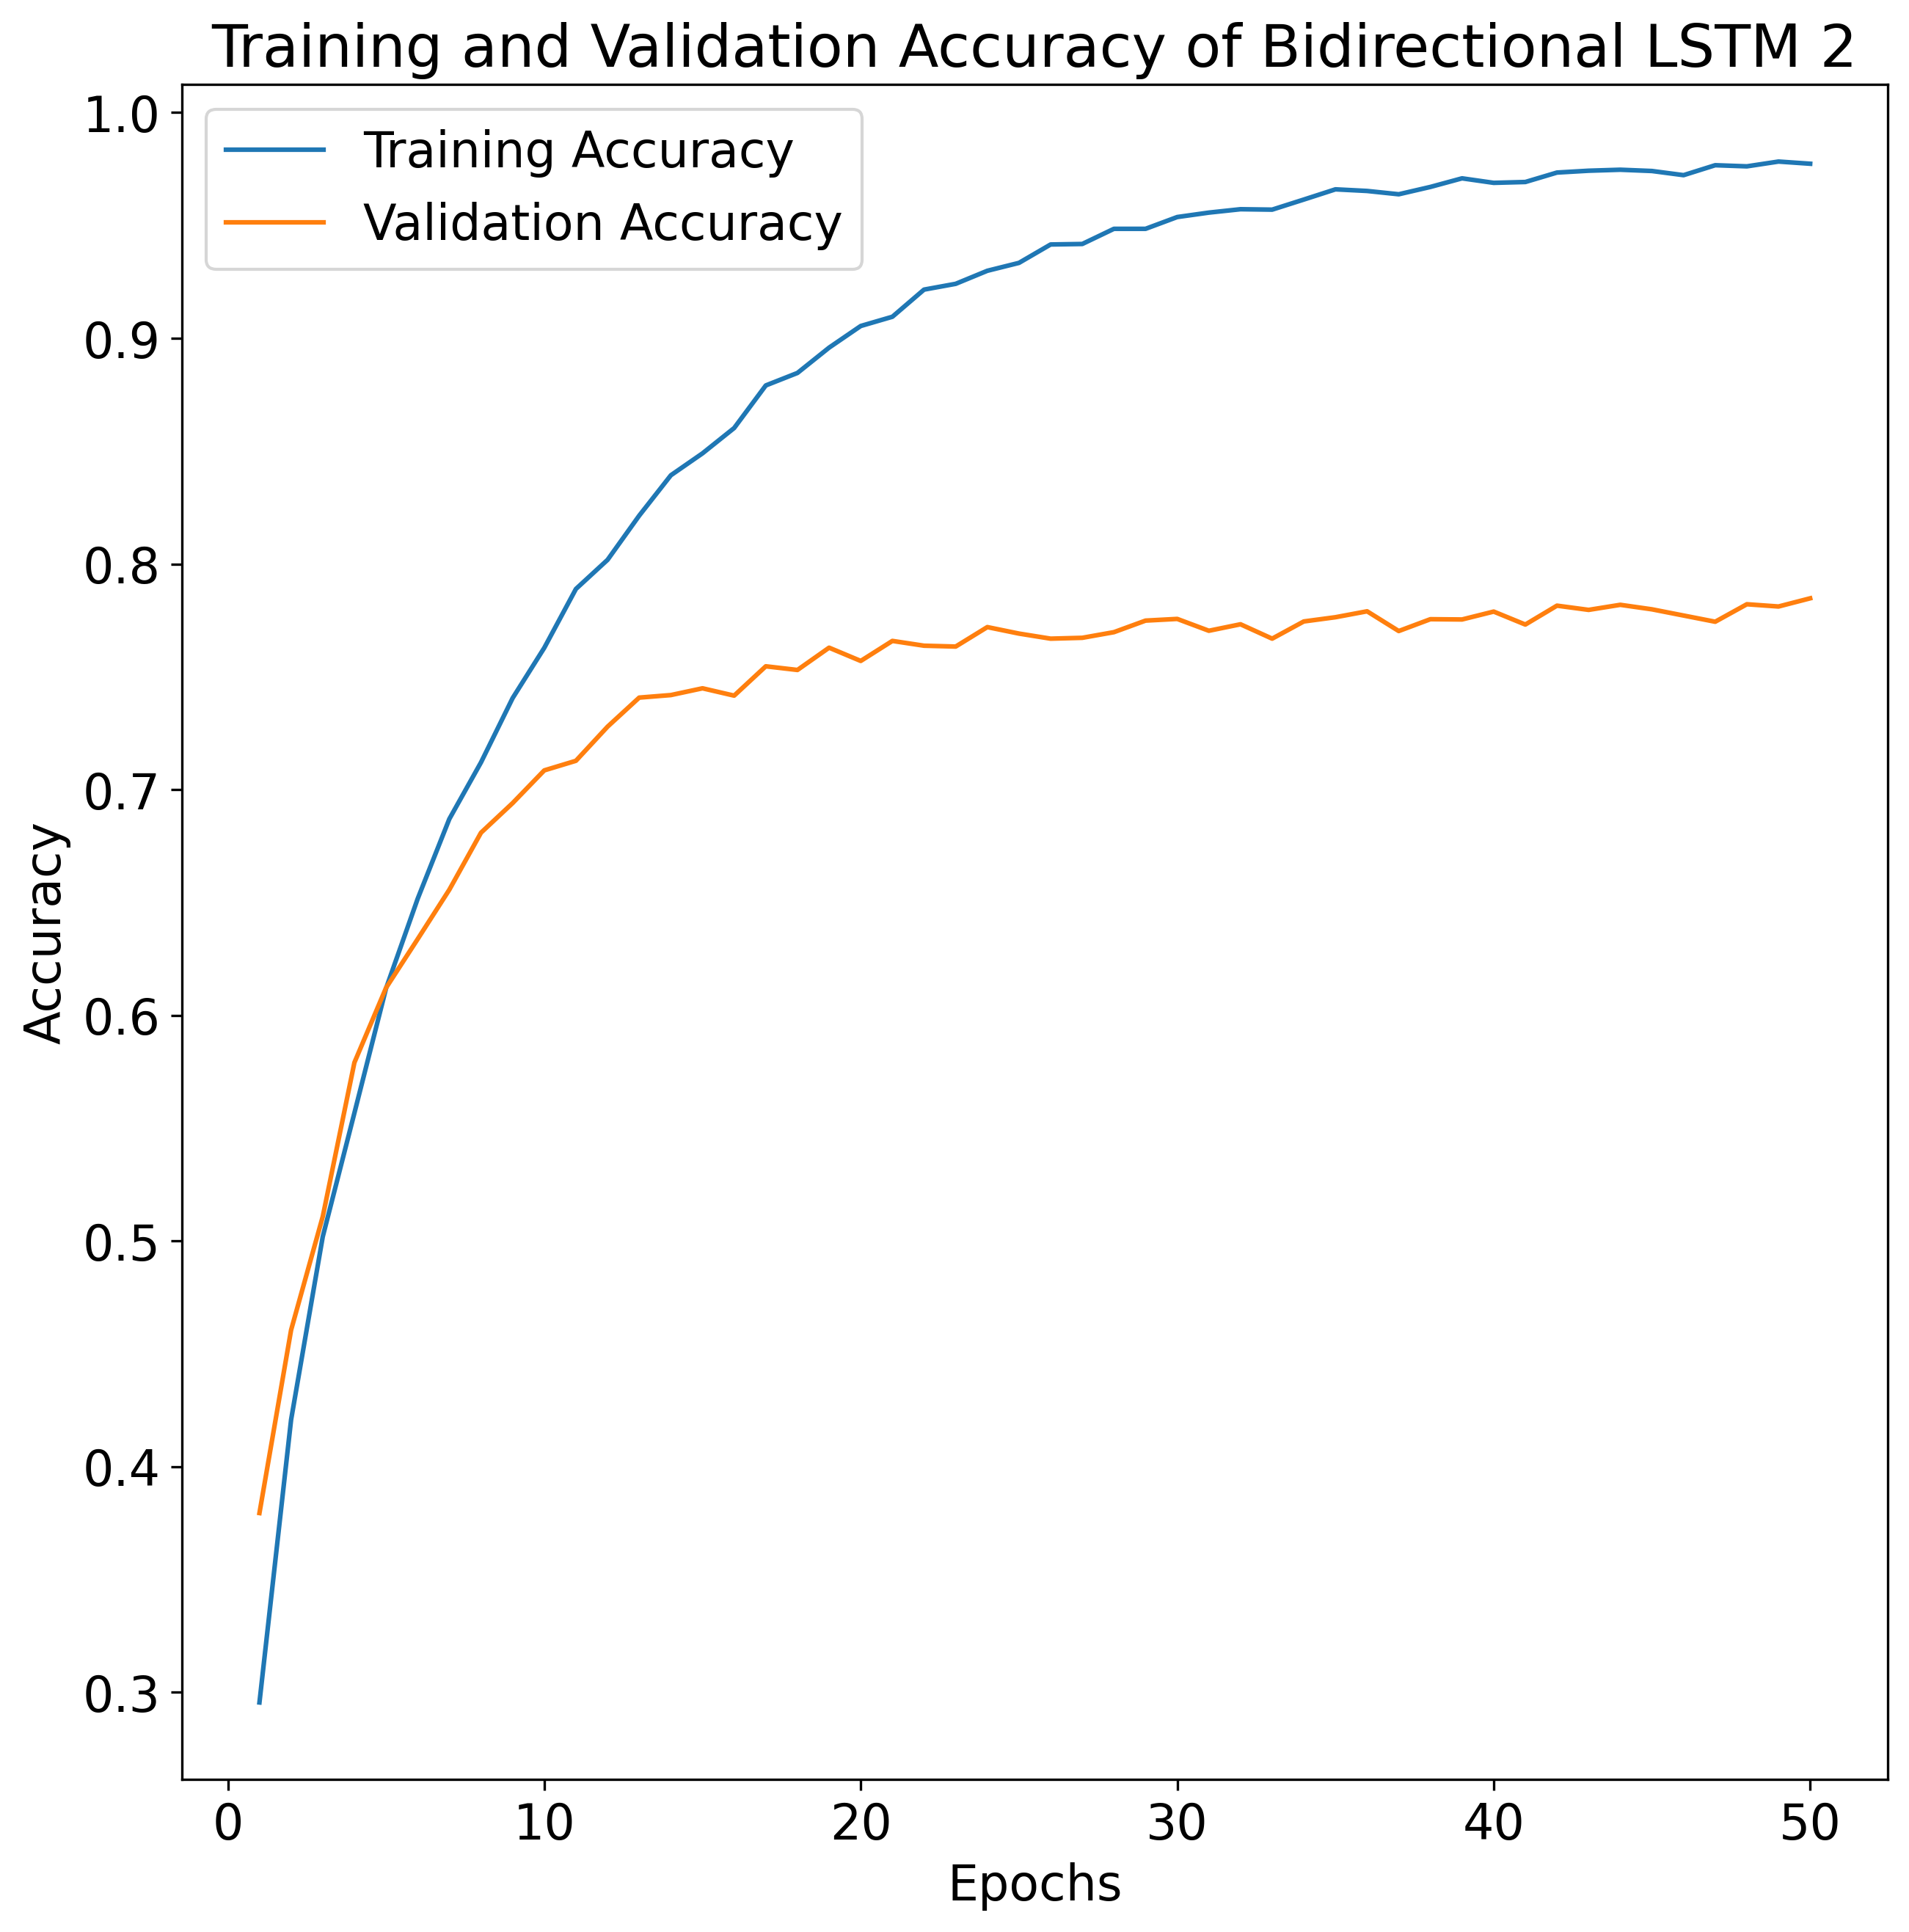

In [28]:
epochs = range(1, len(history_BLSTM_2.history['accuracy']) + 1)
plt.figure(figsize=(10, 10),dpi=300)
plt.rcParams.update({'font.size': 16})
plt.plot(epochs, history_BLSTM_2.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_BLSTM_2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy of Bidirectional LSTM 2')
plt.legend()
plt.savefig('BLSTM_2.jpg')
plt.show()

250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
Confusion Matrix:


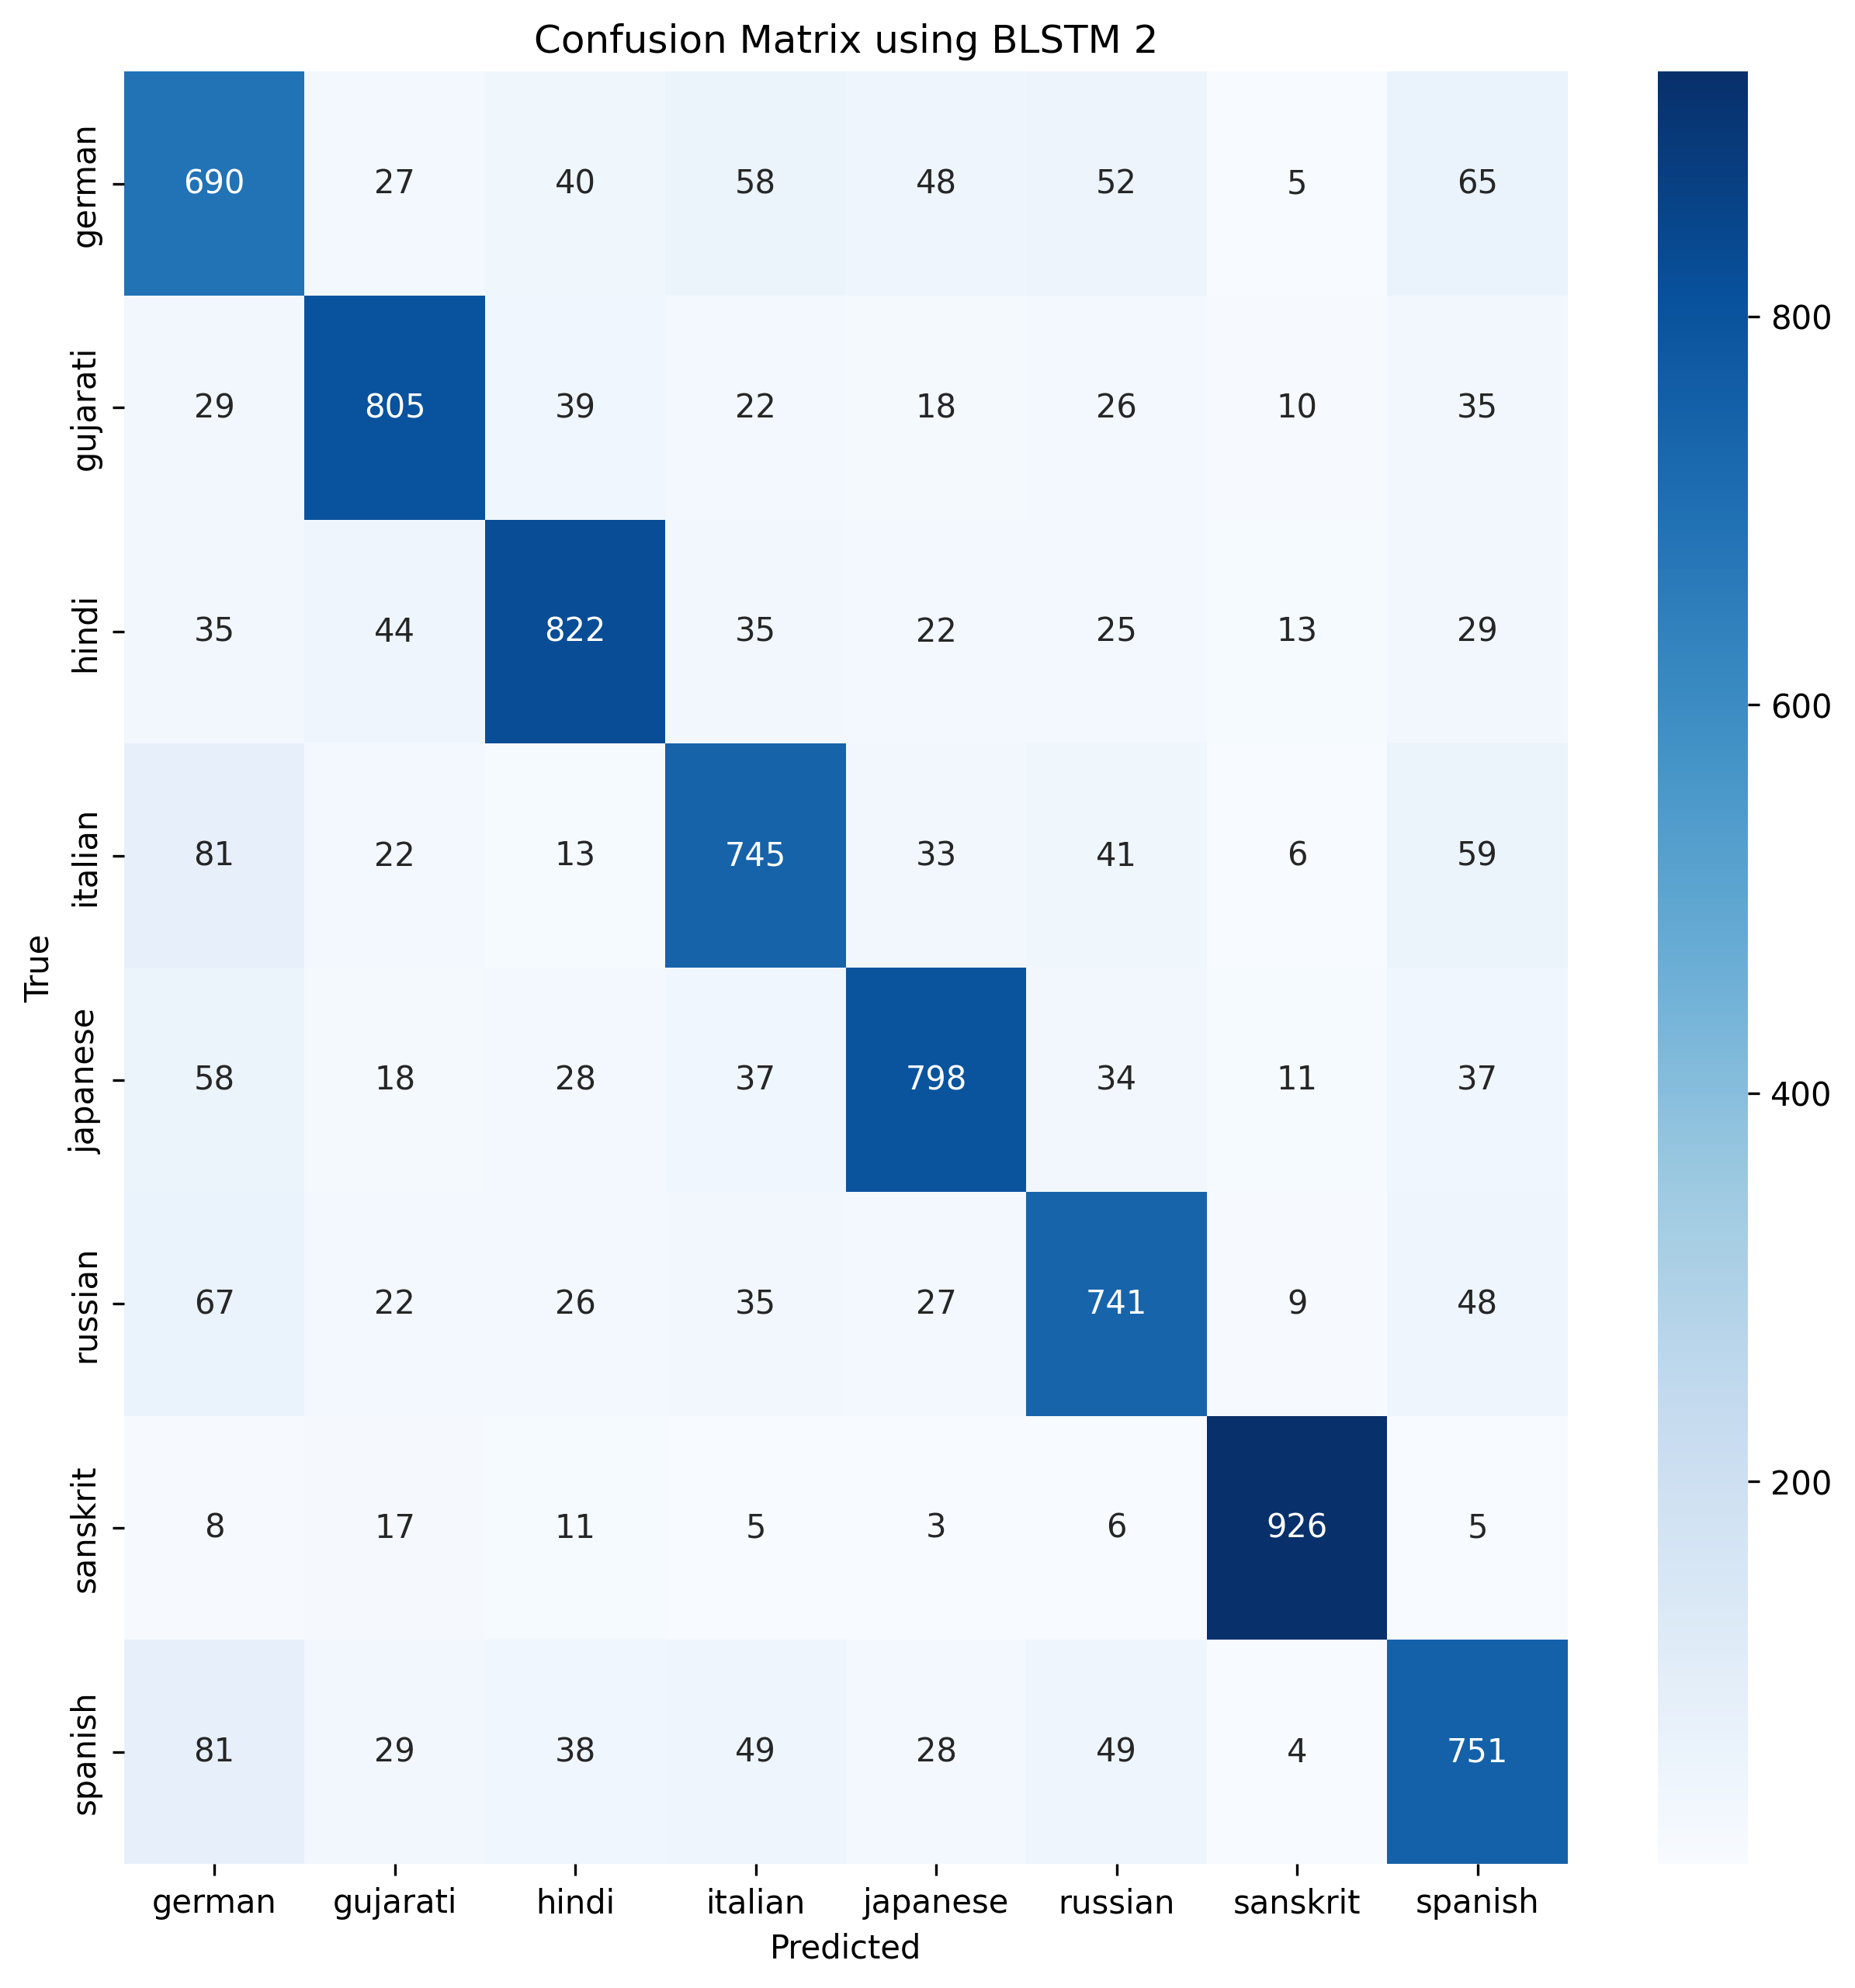

In [29]:
y_pred_prob_BLSTM_2 = BLSTM_2.predict(X_test_reshaped)
y_pred_BLSTM_2=np.argmax(y_pred_prob_BLSTM_2, axis=1)
print("Confusion Matrix:")
encoded_to_original_mapping = {i: original_classes[i] for i in range(len(original_classes))}
cm = confusion_matrix(y_test_reshaped, y_pred_BLSTM_2)
plot_CM(y_test_reshaped, y_pred_BLSTM_2,original_classes,"BLSTM 2")

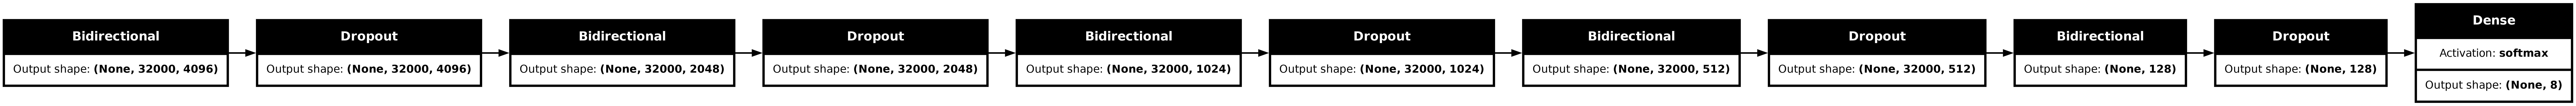

In [30]:
plot_model(BLSTM_2, to_file='BLSTM_2_H.png',dpi=300,show_layer_activations=True,show_shapes=True,rankdir='LR',expand_nested=True)

## **Bidirectional LSTM Model 3 (BLSTM_3)**

In this section, we define and compile a third Bidirectional LSTM model, `BLSTM_3`, with a slightly different configuration compared to the previous models. This model aims to further explore variations in dropout rates and LSTM units to optimize performance.

#### **Model Architecture:**

1. **Input Layer:**
   - Input shape: `(X_train.shape[0], X_train.shape[1])`
   - Defines the shape of the input data.

2. **Bidirectional LSTM Layers:**
   - **First Layer:** 2048 units, returns sequences
   - **Second Layer:** 1024 units, returns sequences
   - **Third Layer:** 512 units, returns sequences
   - **Fourth Layer:** 256 units, returns sequences
   - **Fifth Layer:** 64 units, does not return sequences

   Each Bidirectional LSTM layer is followed by a Dropout layer to mitigate overfitting.

3. **Dropout Layers:**
   - Applied after each LSTM layer with a dropout rate of 0.2.

4. **Dense Output Layer:**
   - 8 units with a `softmax` activation function to classify into 8 categories.

#### **Model Compilation:**

- **Optimizer:** Adam
  - Learning Rate: 0.0008
  - The learning rate is set to 0.0008 to balance convergence speed and stability.

- **Loss Function:** Sparse Categorical Crossentropy
- **Metrics:** Accuracy

The model is compiled with the specified optimizer and loss function, and a summary is provided to review its architecture and parameters.


In [31]:

# Define the model
BLSTM_3 = Sequential()
BLSTM_3.add(Input(shape=(X_train.shape[0], X_train.shape[1])))
# Add bidirectional LSTM layer
# BLSTM_1.add(Bidirectional(LSTM(2048, return_sequences=True), input_shape=(None, 40)))

BLSTM_3.add(Bidirectional(LSTM(2048, return_sequences=True)))
BLSTM_3.add(Dropout(0.2))

BLSTM_3.add(Bidirectional(LSTM(1024, return_sequences=True)))
BLSTM_3.add(Dropout(0.2))

BLSTM_3.add(Bidirectional(LSTM(512, return_sequences=True)))
BLSTM_3.add(Dropout(0.2))

BLSTM_3.add(Bidirectional(LSTM(256, return_sequences=True)))
BLSTM_3.add(Dropout(0.2))


BLSTM_3.add(Bidirectional(LSTM(64)))
BLSTM_3.add(Dropout(0.2))

BLSTM_3.add(Dense(8, activation='softmax'))

# Compile the model
learning_rate = 0.0008  # Set your desired learning rate here

# Create an instance of the Adam optimizer with the desired learning rate
optimizer_2 = Adam(learning_rate=learning_rate)

# Compile the model with the new optimizer
BLSTM_3.compile(optimizer=optimizer_2, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Print model summary
BLSTM_3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_9 (Bidirectional) │ (None, 32000, 4096)    │    35,209,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32000, 4096)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 32000, 2048)    │    41,951,232 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32000, 2048)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 32000, 1024)    │    10,489,856 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32000, 1024)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 32000, 512)     │     2,623,488 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32000, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 128)            │       295,424 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,570,248 (345.50 MB)

 Trainable params: 90,570,248 (345.50 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history_BLSTM_3 = BLSTM_3.fit(X_train_reshaped,y_train_reshaped,epochs=50,batch_size=128,validation_data=(X_test_reshaped,y_test_reshaped))

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 31s 98ms/step - accuracy: 0.2855 - loss: 1.8364 - val_accuracy: 0.4071 - val_loss: 1.5707
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 95ms/step - accuracy: 0.4350 - loss: 1.5052 - val_accuracy: 0.4947 - val_loss: 1.3815
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - accuracy: 0.5059 - loss: 1.3437 - val_accuracy: 0.5476 - val_loss: 1.2817
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - accuracy: 0.5716 - loss: 1.2046 - val_accuracy: 0.6022 - val_loss: 1.1518
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 95ms/step - accuracy: 0.6110 - loss: 1.0862 - val_accuracy: 0.6286 - val_loss: 1.0902
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 95ms/step - accuracy: 0.6551 - loss: 0.9830 - val_accuracy: 0.6391 - val_loss: 1.0296
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 95ms/step - accuracy: 0.6835 - loss: 0.9050 - val_accuracy: 0.6705 - val_loss: 0.9583
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 95ms/step - accuracy: 0.7190 - loss: 0.8078 - 

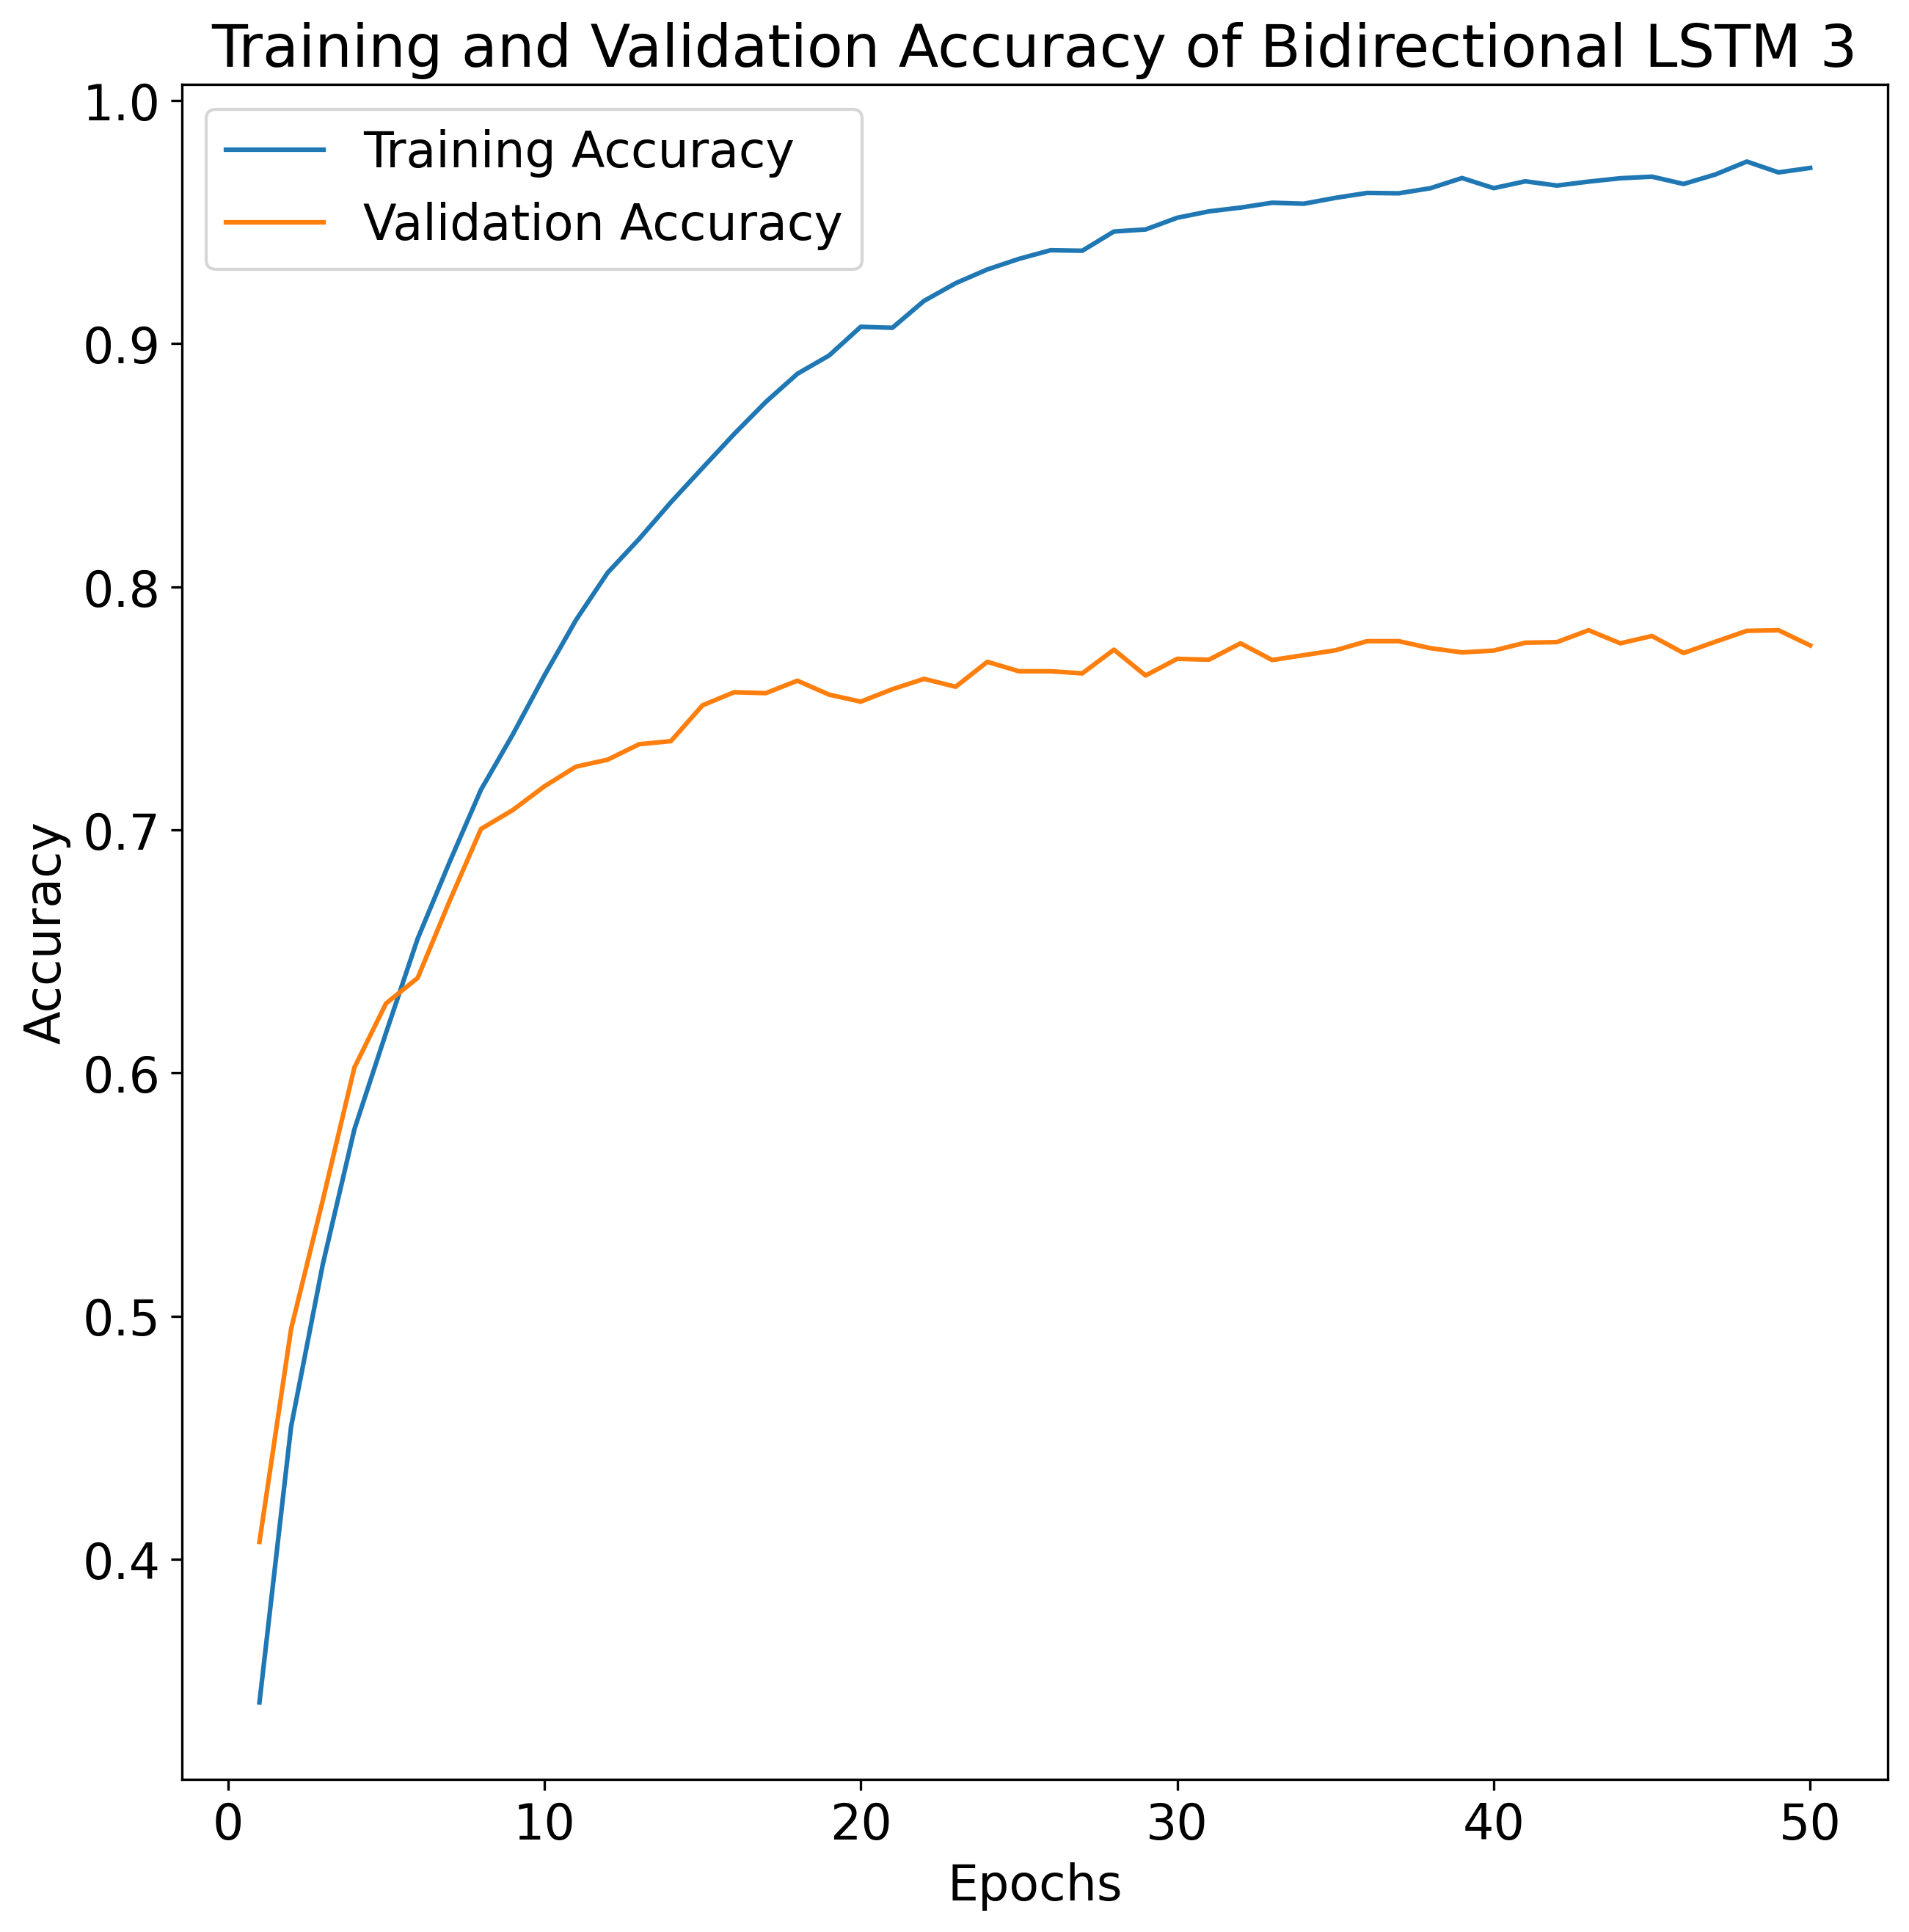

In [33]:
epochs = range(1, len(history_BLSTM_3.history['accuracy']) + 1)
plt.figure(figsize=(10, 10),dpi=300)
plt.rcParams.update({'font.size': 16})
plt.plot(epochs, history_BLSTM_3.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_BLSTM_3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy of Bidirectional LSTM 3')
plt.legend()
plt.savefig('BLSTM_3.jpg')
plt.show()

250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Confusion Matrix:


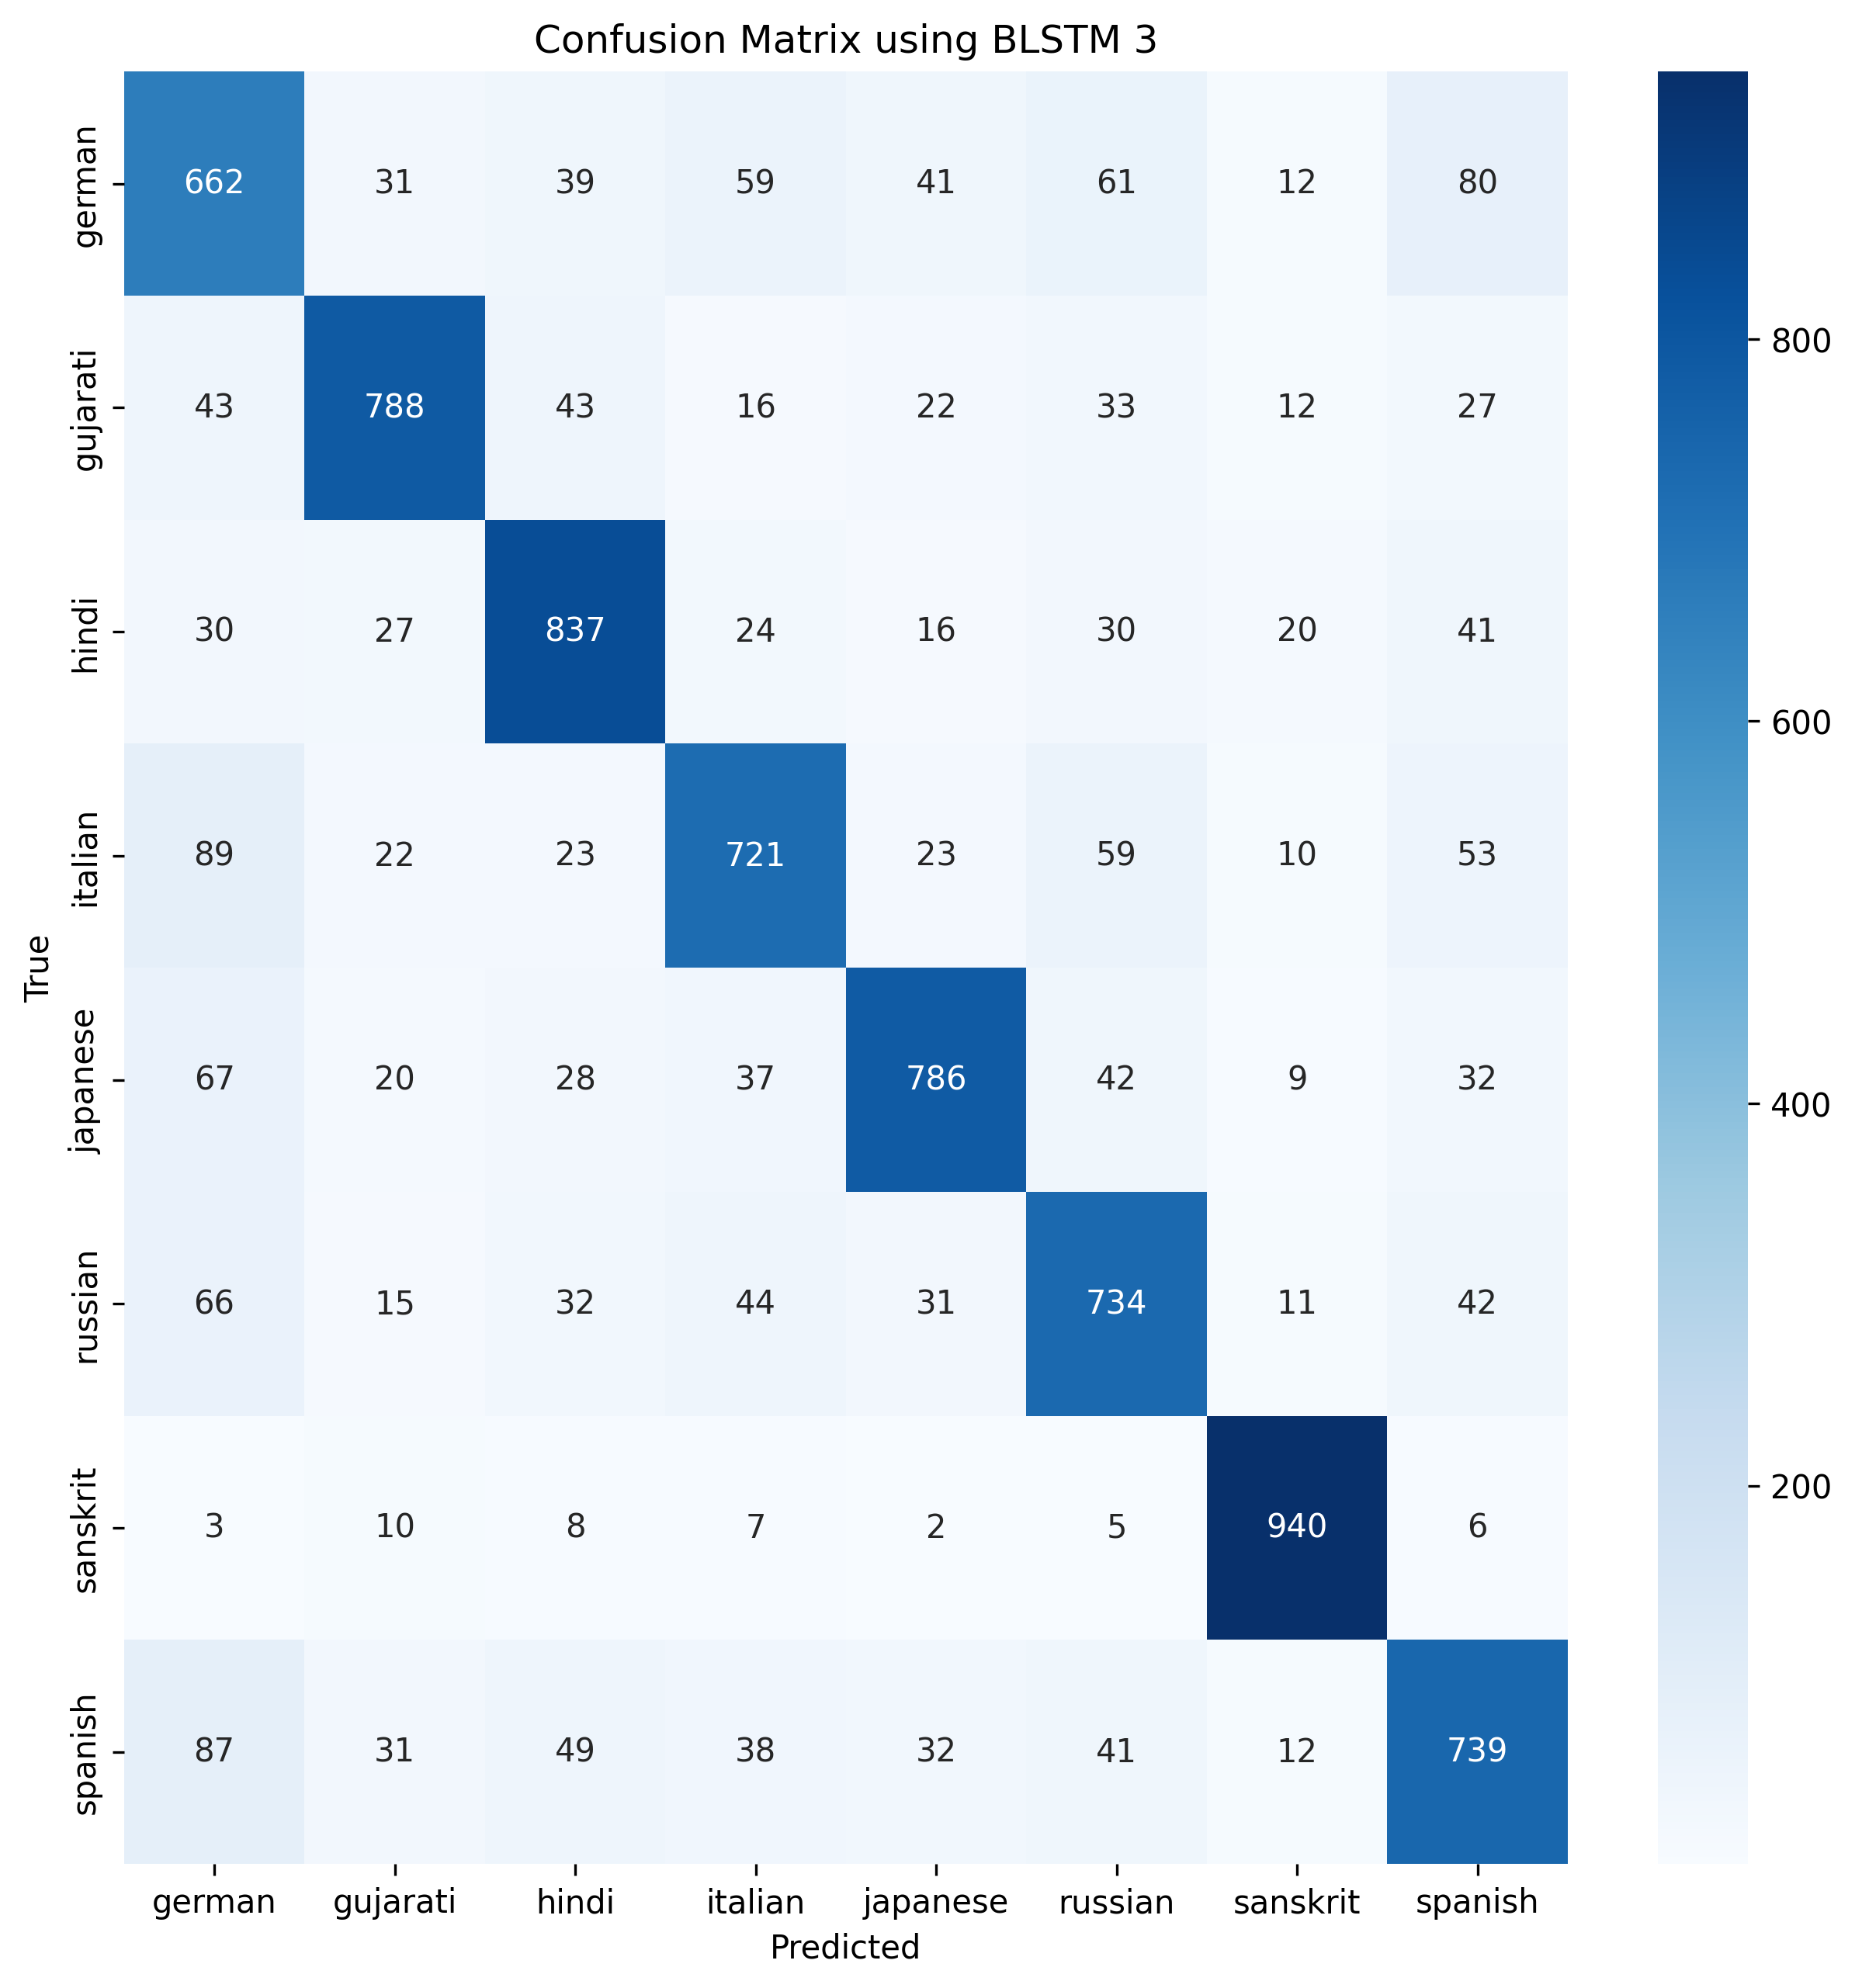

In [34]:
y_pred_prob_BLSTM_3 = BLSTM_3.predict(X_test_reshaped)
y_pred_BLSTM_3=np.argmax(y_pred_prob_BLSTM_3, axis=1)
print("Confusion Matrix:")
encoded_to_original_mapping = {i: original_classes[i] for i in range(len(original_classes))}
cm = confusion_matrix(y_test_reshaped, y_pred_BLSTM_3)
plot_CM(y_test_reshaped, y_pred_BLSTM_3,original_classes,"BLSTM 3")

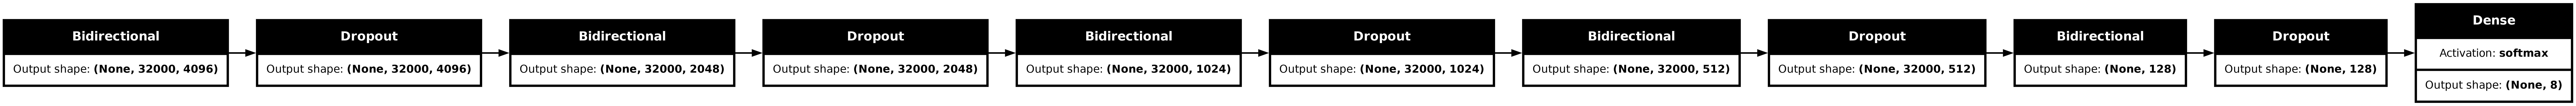

In [35]:
plot_model(BLSTM_3, to_file='BLSTM_3_H.png',dpi=300,show_layer_activations=True,show_shapes=True,rankdir='LR',expand_nested=True)